In [1]:
import numpy as np
import gym
import tensorflow as tf
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

learning_rate = 6e-5
epochs_number = 10000
batch_size = 256
replay_buffer_size = 256
l2_regularization = 0

env_name = 'HalfCheetah-v2'
environments_count = 20

# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

# observations = envs.reset()
# for t in range(100):
#     # print(envs.render(mode='human'))
#     actions = np.stack([envs.action_space.sample() for _ in range(nproc)])
#     observations, rewards, done, info = envs.step(actions)
    

## Define model architecture

In [3]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [4]:
tf.reset_default_graph()

state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

### UNCOMMENT TO ADD RANDOM NUMBER TO INPUTS
#print(state_ph)
#random_ph = tf.expand_dims(tf.random.normal(tf.gather_nd(tf.shape(state_ph), [[0]])), axis=-1)
#print(random_ph)
#input_l = tf.concat([state_ph, random_ph], axis=1)
###

l1 = tf.layers.dense(state_ph, units=32, activation=tf.nn.relu)
mu = tf.layers.dense(l1, units=action_space)

log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
std = tf.exp(log_std)

action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


# Training
weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

action_logprob = gaussian_loglikelihood(action_ph, mu, log_std)
test_debug = (action_ph - mu)**2

all_params = tf.trainable_variables() 
loss_l2 = tf.add_n([ tf.nn.l2_loss(v) for v in all_params ]) * l2_regularization

loss = -tf.reduce_mean(action_logprob * weight_ph) + loss_l2
gradients = tf.gradients(loss, tf.trainable_variables()) # For debug

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
update = optimizer.minimize(loss)

W0719 16:34:33.922208 16872 deprecation.py:323] From <ipython-input-4-e0f14cb426ef>:12: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0719 16:34:33.928189 16872 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0719 16:34:34.395559 16872 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

# sess.run(loss, feed_dict={weight_ph: [0, 1, 2],
#                           action_ph: [1, 2, 3],
#                           state_ph: [[1,2], [1,2], [1,2]]})

In [6]:
def make_reward_to_go(reward):
    return np.cumsum(reward[::-1])[::-1]

make_reward_to_go(np.arange(1, 5))

array([10,  9,  7,  4], dtype=int32)

#TODO: подумать о последствиях слишком большого количества сэмплов в начале (решил рассинхронизацией)

In [7]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    replay_buffer = np.empty((0,3), np.float32)
    
    # [state, action, weight] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(action_op, feed_dict={state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            if dones.any():
                if dones.all():
                    print('WARNING: envs are in sync!!')
                
                done_indexes = np.arange(envs_number)[dones]
                for i in done_indexes:
                    #print(dones, i, len(rollouts[i][:, 2]))
                    history['reward'].append(rollouts[i][:, 2].sum())

                    rollouts[i][:, 2] = make_reward_to_go(rollouts[i][:, 2])
                    replay_buffer = np.append(replay_buffer, rollouts[i], axis=0)
                    rollouts[i] = np.empty((0, 3))
                #history['reward'] = [np.mean(history['reward'])]
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([ -0.13974153,   0.23413068,  -0.09778312,  -0.19384006,
        -0.13219839,   0.61089809,   0.49226578,  -0.49775394,
         1.1938644 ,  -0.09228054,   1.46828569,   7.33583643,
        -9.02268215, -13.34280795,  -1.04330179,   9.57391475,
         0.64543006]),
        array([ 2.8970954, -7.6672187, -3.5205033,  1.2912625, -3.2802527,
       -6.89486  ], dtype=float32),
        -2871.0618],
       [array([-0.04205498, -0.32227457, -0.11498013, -0.49326266, -0.42725721,
        0.62907861, -0.3125281 , -0.59921562,  1.68214605,  1.24439292,
        2.10582193,  4.34655881, -2.67124411,  0.27576235, 19.69018519,
        0.57192057, -9.43039319]),
        array([ 3.7234292, -7.6772065, -4.376007 ,  5.0337205, -4.3776383,
       -8.904251 ], dtype=float32),
        -2321.2244],
       [array([ -0.07053233,   0.06988379,   0.18681316,  -0.43940982,
        -0.3641401 ,   0.5883241 ,   0.23912909,  -0.49902135,
         1.99748099,  -0.38257227,   1.21764471,  17.6999027

## Train agent 

In [8]:
from tqdm import tqdm_notebook

history = {'reward': [], 'loss': [], 'gradients_max_abs': [], 'gradients_equal_zero': [], 'max_action': []}
batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

saver = tf.train.Saver()


# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

max_value = -70

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']

    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-reward-{value}.ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value

#     print(np.array(batch[:, 1].tolist()))
#     print(batch[:, 1].tolist())

#     arr = sess.run([log_std, std, action_logprob, action_op, mu, action_ph, test_debug], feed_dict={
#                                                     state_ph: np.array(batch[:, 0].tolist()),
#                                                     action_ph: np.array(batch[:, 1].tolist()),
#                                                     weight_ph: batch[:, 2]})

#     for k, name in zip(arr, ['log_std', 'std', 'action_logprob', 'action_op', 'mu', 'action_ph', 'test_debug']):
#         print(k[0], name)
#     #print(np.exp(e))
#     print(f'--------- {epoch} ------------')


    _, loss_, gradients_, mu_ = sess.run([update, loss, gradients, action_ph], feed_dict={
                                                    state_ph: np.array(batch[:, 0].tolist()),
                                                    action_ph: np.array(batch[:, 1].tolist()),
                                                    weight_ph: batch[:, 2]})

    
    history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
    history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    
    history['loss'].append(loss_)


Charging generators


Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


## Plot results

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'HalfCheetah-v2')

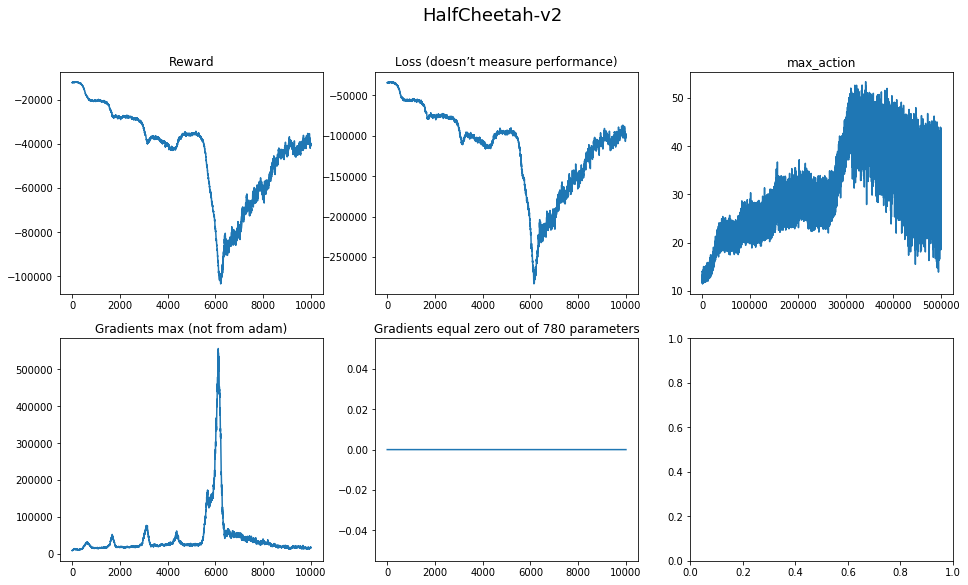

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['loss'], 'Loss (doesn’t measure performance)', axs[0, 1])
plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[0, 2])
plt.suptitle(env_name, fontsize=18)

#plt.savefig('logs/LunarLanderContinuous-v2_fail')

## Our agent

In [11]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(action_op, feed_dict={state_ph: [observations]})
    
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])

    print(rewards, actions[0])


    if dones:
        observations = env.reset()
        print('Done')


Creating window glfw
0.32003699133194585 [ 0.60259616 -1.6246188  -0.27706736  0.96186453 -0.86003804 -1.0191206 ]
-702.7303955003741 [ 19.498377 -48.25618  -14.951125  38.04464  -31.966763 -40.42284 ]
-49.08842471953994 [  5.5160775 -12.047958   -3.579712    9.505969   -9.986181  -10.69394  ]
-1.3367883697774994 [ 2.1441905  -1.9228315  -0.32801968  1.2510086  -1.2260467  -1.7937542 ]
-0.7711932123596863 [ 0.7072468  -1.096725    1.9839253   1.168622   -1.920702   -0.36214498]
-4.20308577259443 [ 1.2702773 -1.4383876  1.4017292  4.182741  -2.8595903 -3.2659538]
-6.321140094664193 [ 1.2588297  -4.480203   -0.84624803  3.9929068  -3.8846164  -3.0020907 ]
-753.7109135016487 [ 31.649292 -48.38916  -17.36733   35.98476  -22.552944 -45.67435 ]
-3.9830849266317236 [ 1.3583275 -3.767022  -1.1326087  3.5273025 -2.3963175 -1.7927964]
-4.185507618830141 [ 2.8361673 -3.527589  -0.8616201  3.2735868 -2.266561  -2.050752 ]
-12.463911467423566 [ 2.966197  -6.2527685 -1.3803666  6.033618  -3.7203758 

-8.250885869753805 [ 3.269948  -4.226133  -2.4246268  4.655847  -3.468308  -3.746281 ]
-10.48713476169189 [ 2.461149  -5.9535594 -1.9417222  4.3938665 -3.956114  -4.947386 ]
-10.585936979368451 [ 2.8175807 -4.8565483 -1.7085298  4.3450017 -4.5664268 -5.6266594]
-13.742864800680842 [ 3.4756489 -6.73635   -1.5644473  5.0061207 -3.4920866 -6.3506923]
-12.16114506389623 [ 2.7675967  -6.9277005  -0.79121625  4.9267664  -3.530262   -5.3628883 ]
-10.321728760659777 [ 3.1675475 -5.70948   -1.424726   5.291492  -3.1025152 -4.584531 ]
-11.343021387629129 [ 2.924344  -6.5344515 -1.7459188  4.757799  -3.1941066 -5.13387  ]
-9.500234693442174 [ 2.304874  -4.8709416 -1.1755575  3.7036045 -3.8534229 -6.001893 ]
-10.457417322018678 [ 2.6178246 -5.654347  -1.8575555  4.549775  -3.9267669 -5.1123495]
-9.719193544064948 [ 2.708171  -4.9796987 -0.6970834  4.6375    -4.076122  -5.151177 ]
-7.366322546123231 [ 2.1219647 -4.5362225 -0.8691977  3.690494  -4.179475  -4.0929656]
-16.46324110043098 [ 4.475042  -

-1.7406865457703549 [ 0.6105878 -1.9723802  1.4499469  3.2219694 -1.2244291 -1.0811627]
-2.5400448994319733 [ 2.422692  -3.1336503 -0.4100967  1.452041  -2.69058   -1.8029113]
-570.0941447995849 [ 25.571909 -43.307045 -12.915968  32.23865  -21.59884  -38.72638 ]
-10.771477302982136 [ 3.0874987 -5.6359577 -1.9171841  3.9570184 -4.8265963 -4.7455664]
-2.566671987484881 [ 1.5510511  -2.658049   -0.30813318  2.5874524  -2.687896   -0.798494  ]
-1.1902762800316316 [ 1.8491348  -0.85256106 -0.22810185  0.29542094 -1.1313932  -1.6916443 ]
-4.235944977773824 [ 3.2813406 -4.412058   1.3974078  0.9436819 -2.8030224 -0.6781632]
-4.17152896437309 [ 0.87941927 -3.3286278  -0.0674997   3.8381777  -3.6566508  -1.7118797 ]
-196.08453757277056 [ 15.163854 -25.17862   -7.478961  19.796127 -12.866935 -21.98453 ]
-317.42263860905933 [ 20.715832 -31.401882 -11.088985  23.585497 -15.090025 -29.170227]
-3.0570099784362053 [ 1.9724734  -3.9529705  -0.19488937  1.9501321  -2.268097   -1.410778  ]
-1.8065012587

-95.6956098673781 [ 10.543328 -17.44528   -5.698106  12.975407  -9.495251 -15.808057]
-308.4778147837261 [ 20.78532  -30.789307 -10.198446  23.037342 -15.075731 -29.016203]
-2.718167027627906 [ 2.4387183 -3.1300962  0.3728118  2.3548117 -1.7629791 -1.9237914]
-2.315238918220854 [ 1.093466  -2.3807592  1.329429   1.764333  -2.7865343 -2.335948 ]
-3.9434621500285347 [ 1.4281785  -3.6692781   0.37372518  2.9547117  -3.398878   -2.1213462 ]
-137.70296556517246 [ 12.85822  -21.679375  -7.133785  14.92573  -10.36893  -18.952059]
-430.58235064121396 [ 24.615416 -35.915417 -12.376594  27.393183 -16.803305 -34.95658 ]
-0.7069226454890043 [ 0.33295518 -0.8439517  -0.53323525  0.7427318  -0.73396385 -0.28040206]
-2.30344645350792 [ 1.497099  -2.9052196  0.9422974  2.0786684 -2.0610209 -1.7803183]
-15.736735855133421 [ 1.8870177  -4.9225726   0.79482824  6.3390155  -8.885129   -3.7368333 ]
-42.4162546346225 [  4.5915265 -12.055952   -4.73762     9.141611   -7.5366287  -9.828605 ]
-583.330801357753

-1.1190354536350615 [ 1.6746459  -1.7934861   0.72524214  1.2492706  -2.1492596  -1.0098004 ]
-4.648533503533686 [ 2.860604  -3.1438794  1.4363627  2.4476955 -3.8972101 -2.8522105]
-2.6735197922132987 [ 1.7488488 -2.8568199 -0.2453576  2.4066122 -3.0271382 -1.5591259]
-375.8136506912165 [ 23.141432 -34.17349  -11.306222  25.407448 -15.960203 -32.041668]
-15.03823398277247 [ 3.9885347 -6.353947  -2.2071824  5.660838  -5.338936  -5.2243094]
-2.3281992434729153 [ 0.94465953 -2.6031077   0.40449452  2.3065276  -1.8061066  -2.609894  ]
-3.7165059515921497 [ 1.7542045 -2.6788397  2.488696   2.2104046 -3.6311882 -1.9555535]
-5.353033237591269 [ 2.4852161  -3.865819    0.32195684  3.4616919  -4.0146937  -2.302218  ]
-164.63770194703065 [ 14.460629  -23.02957    -7.1968107  16.594225  -12.209588  -20.743536 ]
-406.2054274708173 [ 22.818491 -35.039062 -12.981787  27.754005 -16.700844 -33.079994]
-1.1222251654572104 [ 0.60470796 -2.1789021   1.653232    0.81909835 -0.7212522  -1.0162054 ]
-8.4324

-11.15450227291793 [ 3.814974   -6.4612546  -0.75764686  4.864691   -2.9517465  -4.722599  ]
-8.710530483440383 [ 3.2440472 -4.706355  -1.8028784  4.300523  -3.451894  -4.5189   ]
-10.499219338090551 [ 2.4084659 -6.1344323 -1.3039658  4.4554687 -3.100993  -5.4742517]
-12.745677665693021 [ 2.9150126 -6.6236463 -1.821219   5.8825893 -3.9597318 -4.5915084]
-11.575971978672325 [ 2.8108113  -5.996093   -0.35744452  4.737249   -4.009979   -5.792665  ]
-1.561163488200352 [ 0.81600493 -2.589031   -0.4734375   1.576522   -1.6619343  -1.7515147 ]
-1.1525523369337973 [ 0.8153745  -2.0682607   0.35789478  2.164386   -1.58418    -0.78159744]
-1.1564996298610581 [ 0.9776603  -1.465876   -0.7103377   2.4240026  -2.1253679  -0.25646198]
-157.8208344276281 [ 12.516617 -22.28814   -9.119721  18.018475 -11.682481 -19.559116]
-28.3304548557198 [ 6.488306  -8.991382  -1.6185308  6.612166  -6.848824  -8.324343 ]
-11.642565466903559 [ 3.7731252 -6.5940366 -1.6695327  4.11376   -3.384256  -5.376665 ]
-9.24264

-11.368343900349632 [ 3.6399055 -6.4949207 -1.0149462  4.6172485 -2.7007387 -5.3490415]
-9.500078798864179 [ 2.664598  -5.8279643 -1.7736834  4.1077685 -2.4401388 -5.2881746]
-11.660122304181478 [ 3.2423673 -5.8972054 -0.5924299  4.643431  -3.616446  -6.051074 ]
-4.49780119313828 [ 2.1648202 -3.958256  -1.0061432  2.074924  -2.8142998 -3.4144926]
-14.460689045443829 [ 3.6719882 -6.676189  -1.4230163  5.544542  -4.5001316 -5.8218236]
-10.30889989565322 [ 2.673699  -6.251609  -1.6122617  3.999528  -3.4750242 -5.150452 ]
-11.433333725530801 [ 3.0702496 -4.932786  -1.5441862  5.1229787 -4.62021   -5.551738 ]
-11.686956432075098 [ 3.239931  -5.9123025 -1.0300784  4.734676  -4.806924  -4.989596 ]
-11.17947351284284 [ 3.457576  -5.383381  -1.4457042  4.472107  -4.7480426 -5.114869 ]
-11.086435380735953 [ 3.5293157 -5.78412   -1.6017954  5.1726813 -2.9916928 -5.152404 ]
-11.093804956219902 [ 3.0493937 -6.227259  -1.0441906  4.5323644 -2.9284103 -5.701329 ]
-9.916853383376282 [ 2.242206   -5.11

-12.233058361592143 [ 3.6193006 -5.8049765 -1.9988815  5.4961796 -4.2638497 -4.8108077]
-11.948295982248293 [ 3.5195968 -6.914414  -1.4634833  4.8927298 -3.3683584 -4.6744895]
-13.088288502161786 [ 2.321339  -6.646515  -1.9117914  5.1252546 -4.217971  -5.7960534]
-9.798660264168214 [ 3.8744373 -4.953038  -2.2681558  4.338537  -3.331201  -4.8343906]
-10.280876619833302 [ 2.2259822 -6.3835187 -1.9999584  4.474408  -3.3496518 -4.675505 ]
-11.252974977662014 [ 2.2002108 -5.664113  -2.2483053  5.0881515 -3.450001  -5.723557 ]
-9.49632128346021 [ 2.49306   -6.2176266 -1.6997131  3.385345  -3.2187648 -5.0378537]
-9.73931159352183 [ 2.3906338 -5.451536  -1.6650509  4.3366346 -4.308898  -4.670671 ]
-12.098068421407639 [ 2.6089923 -5.773586  -2.0267935  5.783803  -4.3578515 -4.928503 ]
-11.428280149512336 [ 3.011518  -6.095362  -1.5509573  3.8751366 -4.0722322 -5.8357487]
-12.305717562166022 [ 3.6777735 -6.8195252 -2.0519724  4.3951516 -3.5346253 -5.196532 ]
-12.328524531627252 [ 2.522343  -6.71

-10.890405508835743 [ 3.0337272 -6.424889  -2.243712   3.7368236 -3.4834952 -5.2027493]
-9.201664583852681 [ 2.579093  -5.654068  -1.5918629  4.354617  -2.7362761 -4.926009 ]
-10.087955478056987 [ 3.2574747 -4.6652493 -1.7216539  5.307301  -4.2592754 -4.3732705]
-9.645686148735024 [ 3.635639  -4.2578516 -1.8885015  4.3669357 -3.697746  -5.357548 ]
-10.49439607211571 [ 2.7278433 -4.415039  -2.093382   4.88152   -4.375356  -5.5279164]
-12.259439663693552 [ 4.5497775 -6.5627794 -1.7517004  4.8611984 -2.8990192 -4.860744 ]
-9.222454772315977 [ 3.1211746 -5.9158587 -1.2105862  3.5598822 -3.5711138 -4.5290627]
-9.972686147319981 [ 2.8428307  -5.7691026  -0.88852733  4.962579   -3.1872287  -4.769159  ]
-11.667393028780104 [ 2.7281518 -5.961234  -1.2159146  5.082222  -3.7479517 -5.681473 ]
-12.977840923996634 [ 3.6843736 -5.8064585 -1.7877158  6.1595707 -3.891799  -5.1142945]
-10.650486734311304 [ 2.1453347 -5.931835  -0.9647013  4.56917   -4.3969345 -5.0526733]
-9.781658832028542 [ 2.6175735 

-5.195051756975451 [ 1.7733563  -2.3834128  -0.13478588  3.5338416  -5.172702   -2.563586  ]
-342.88618199240074 [ 21.341362 -33.05551  -11.028743  25.38042  -14.517547 -30.063408]
-18.151578796754535 [ 4.885444  -7.700594  -1.8564495  6.6649785 -3.32654   -6.2518415]
-3.179184293431279 [ 1.9552879 -2.7943563 -2.01726    2.0384173 -2.5039947 -2.3945596]
-13.994152650289887 [ 2.226892  -6.9309096 -2.4077866  5.525568  -3.6818209 -6.073127 ]
-10.439179751130991 [ 2.7011395 -5.9150505 -1.9430599  4.2838984 -4.755417  -4.127317 ]
-10.495408188453528 [ 3.0878599  -6.3605437  -0.86996216  4.659111   -2.7991316  -4.9348073 ]
-9.245532762322572 [ 2.715424   -5.9097276  -0.84906507  4.2596626  -3.0305     -4.674592  ]
-11.55280621108846 [ 1.7566007 -6.3827915 -1.6291016  5.745945  -3.6707258 -4.724796 ]
-9.787405147907407 [ 2.4752822 -5.7202983 -2.4657605  4.137849  -3.4417944 -4.8783593]
-12.160788969642166 [ 3.127168  -6.1657777 -1.4571053  5.7045507 -3.6703188 -5.053436 ]
-9.668740686565755 

-3.248902666877521 [ 0.9934442  -3.488321   -0.80936927  1.6649255  -3.008397   -2.7495751 ]
-38.33203236975737 [  5.7766585 -10.828753   -3.5727675   8.569003   -6.537912  -10.195632 ]
-7.943075112358445 [ 3.1285794 -5.7412515 -1.8438253  2.96416   -2.636547  -4.223854 ]
-9.029967363549645 [ 2.5554032 -5.369282  -1.4948981  3.9426413 -3.4222791 -5.0438476]
-9.504196535482832 [ 3.682614  -5.5615134 -1.431222   4.665773  -2.9057305 -4.2444944]
-8.685947930044014 [ 1.6909229 -4.9676313 -2.1199684  4.4469614 -2.6884265 -5.238476 ]
-10.377715987363757 [ 3.281609   -5.385062   -0.62772775  5.130713   -4.380485   -4.2405496 ]
-5.185497147524139 [ 2.2298856 -3.6876302 -0.6348175  3.7236993 -3.246032  -2.9641073]
-9.42100590412371 [ 2.8305998 -5.069813  -2.3458376  3.8903754 -4.285436  -4.654711 ]
-12.423601942031915 [ 3.5819762 -5.4688373 -2.0058665  5.4542723 -4.1483283 -5.553681 ]
-9.236666663438129 [ 3.3891344 -5.836697  -2.1889973  3.4767833 -3.1521215 -4.5019298]
-12.964279293489827 [ 2.

-10.0905424373388 [ 4.030895  -4.541334  -0.8630127  4.1655664 -4.719222  -4.579956 ]
-7.018214011882357 [ 2.3866894 -5.075036  -1.3602339  3.0945992 -2.4838328 -4.345402 ]
-7.748004932688689 [ 0.7872361 -4.8550425 -1.3535707  4.405227  -1.9444191 -5.05231  ]
-3.4344718875904245 [ 2.023161   -2.6667812  -0.38859633  3.2470543  -1.7801924  -2.8231676 ]
-4.855174610109092 [ 1.8319728 -4.4203324 -0.7963161  2.6642184 -3.7551987 -1.8978548]
-33.06821185978665 [  6.0732822 -11.296143   -3.7290473   7.336224   -5.786304   -8.043444 ]
-8.14211215023563 [ 3.1544385 -5.033837  -2.6232805  3.7678337 -2.6288307 -4.285526 ]
-9.185281487062724 [ 2.45603   -5.104725  -2.1361473  4.3285074 -3.0192313 -5.252081 ]
-9.921894277671875 [ 2.8604925 -5.7573004 -1.0425992  4.8044596 -4.2813096 -3.9237108]
-11.290984119221914 [ 2.6805737 -5.510258  -2.3571448  4.033185  -4.179489  -5.9886975]
-12.031386308988225 [ 4.005051  -6.514277  -2.2691875  4.223157  -4.239256  -4.5420785]
-11.103988569995789 [ 2.578566

-10.76501502852765 [ 3.050883  -5.9242334 -1.4902592  4.3464622 -4.348557  -4.8081365]
-10.349790879218624 [ 3.2485998 -5.749966  -1.2080123  3.636568  -4.469116  -5.0176387]
-10.324791605374115 [ 3.0751574 -5.9755936 -1.2929702  3.9082408 -3.7606924 -5.1936693]
-8.621162509572576 [ 2.7929997 -5.1354766 -1.8032327  3.7736201 -2.8268595 -5.151888 ]
-10.05588675716789 [ 3.1084054 -5.354091  -1.6340898  4.831605  -3.5083306 -4.8876605]
-10.479968860444083 [ 3.3093436 -6.67053   -1.2248243  4.4063025 -3.1443615 -4.303362 ]
-11.008590658645891 [ 2.9480236 -5.612904  -2.396981   4.130224  -3.6636615 -5.7982965]
-10.147431817963305 [ 3.389639  -6.0342426 -1.3126676  3.7810712 -3.35135   -5.125319 ]
-11.270733074769172 [ 2.0788233  -6.272104   -0.66418636  5.1795664  -3.8979743  -5.1687717 ]
-7.767674097006369 [ 2.4198527 -3.9137506 -2.335497   4.200121  -3.7239144 -4.426495 ]
-11.46301795154465 [ 3.430741  -6.281391  -0.1416409  5.012     -3.089377  -5.450866 ]
-1.523591734205294 [ 2.0498705 

-10.776087972057226 [ 3.3765302 -6.1634    -1.8188306  4.5804014 -3.5333076 -4.647264 ]
-10.253609973898932 [ 3.6118572 -5.177816  -1.174429   4.8212967 -4.017894  -4.680993 ]
-9.0947453980725 [ 2.160487  -4.9551    -1.6910458  4.761158  -3.2933276 -5.03507  ]
-10.551292583435464 [ 3.1215436 -6.5655346 -2.3361766  4.354109  -2.976631  -4.4029746]
-10.297426942797557 [ 2.772118  -5.8485565 -1.5657213  5.041326  -3.4253764 -4.6351056]
-10.19019511612125 [ 2.8701866 -5.629212  -2.1145923  4.225203  -3.1628485 -5.44501  ]
-9.512415549169553 [ 1.9265363  -6.077396   -0.90610665  4.7594256  -3.989156   -3.8875232 ]
-9.575717070593633 [ 4.092589   -5.831364    0.06697857  3.4761124  -3.6236978  -4.582826  ]
-1.6459640745882345 [ 2.0714474  -1.7967093  -0.12070066  1.8115746  -2.7470367  -0.26321244]
-2.2413676657808503 [ 0.38289922 -3.2602916  -0.18110958  2.8467433  -0.8387282  -1.6483157 ]
-12.50848250912245 [ 5.321135  -6.000341  -1.0620781  2.7118042 -4.647401  -5.670046 ]
-286.2511406379

-12.271486002912308 [ 2.8679035 -6.187914  -2.0062702  5.180835  -4.0881886 -5.3498144]
-12.032790547344396 [ 2.8424087 -5.798155  -2.3023605  4.5866175 -4.5890007 -5.584866 ]
-10.130596110019443 [ 3.3891835 -5.423504  -2.078637   4.64731   -2.4414368 -5.334298 ]
-9.542433714433137 [ 3.3490176 -5.7360153 -0.9527036  4.6150336 -2.593528  -4.722341 ]
-10.879309547956543 [ 2.9026892 -6.419299  -1.8214079  4.306319  -3.8249574 -4.752544 ]
-11.03907923245211 [ 2.3698163 -6.4254565 -1.6440785  3.730929  -4.089453  -5.4842715]
-12.449353421712535 [ 3.0161347 -6.2385244 -1.9715947  5.3129563 -3.9756536 -5.3395066]
-11.352001978072373 [ 2.7707393 -5.9205365 -2.9476852  5.193006  -2.34105   -5.442894 ]
-9.651438427357904 [ 3.5243523 -5.339795  -1.2344465  3.7506697 -3.8394103 -5.0232434]
-10.386712124271575 [ 2.8832316 -5.34169   -1.3713659  5.268657  -3.6020956 -4.9396186]
-12.411416151588174 [ 2.9860835 -6.7006745 -1.6130021  4.559677  -4.274368  -5.35093  ]
-12.356339757550208 [ 2.3575027 -5.

-9.744596096020814 [ 2.3299687 -5.218698  -2.6655602  3.7021794 -4.2510204 -5.0861034]
-11.100828101002222 [ 2.568914  -6.4106216 -1.3213427  4.832129  -3.8396912 -4.8443513]
-11.030026448528819 [ 3.765589  -6.083494  -1.9090661  4.7417502 -3.026575  -4.8817973]
-11.366613614919071 [ 2.1081266 -6.2266026 -1.3805124  5.355359  -3.9068952 -4.961512 ]
-10.268990554756595 [ 2.9044604 -5.2179203 -1.36859    3.939256  -4.1175523 -5.7179403]
-10.103084508113612 [ 3.8822744 -4.638958  -2.335444   4.8618546 -2.9955835 -5.136087 ]
-11.213385728426873 [ 2.4829168 -5.5516133 -0.5815507  4.793179  -3.742968  -6.175279 ]
-4.208860613588238 [ 2.0791652 -3.6919987 -1.0246992  2.9619853 -2.5168347 -2.8741808]
-14.455157230232029 [ 4.1454654 -7.4497514 -2.5646477  4.401278  -4.3663692 -5.2173905]
-11.274011298566702 [ 2.811139  -5.943239  -1.874613   5.713307  -3.818226  -4.3740635]
-13.180999194145762 [ 2.5673268 -6.647659  -2.335487   5.6914587 -3.9685657 -5.2593412]
-10.691880229118992 [ 1.9507433 -5

-1.7660520224643204 [ 1.7151426 -1.4433115  0.2976459  2.7295444 -2.2155135 -0.6285944]
-2.0368101178142557 [ 0.8340138  -1.7809895   0.10546818  2.8241737  -2.4591768  -1.3983898 ]
-16.73741677068546 [ 4.699818  -6.9203568 -3.37635    5.769276  -3.2481437 -6.4351134]
-323.40726315568804 [ 20.27552  -32.492115 -10.713482  23.516754 -16.953949 -28.475803]
-2.531209560030386 [ 1.5676823 -2.823898  -0.2733733  2.250171  -1.0434747 -2.979182 ]
-1.722171780779564 [ 1.3999041 -2.0857005  0.2616715  2.3504522 -2.5266714 -0.7307267]
-1.5758999495402843 [ 1.0098941  -1.8174562  -0.12560362  2.4865773  -1.9551957  -1.7686288 ]
-50.99618695049631 [  8.189166  -13.2719965  -4.237983    8.843674   -6.8143625 -11.1634245]
-235.77264801790318 [ 18.843117  -26.610985   -7.9455757  20.350504  -13.749329  -25.065397 ]
-2.3196276048649076 [ 0.96972024 -2.953515   -0.43331966  1.8690999  -2.541717   -2.0458567 ]
-1.2128886195652415 [ 1.5143769 -2.2668874  1.1393268  1.2080011 -1.8026832 -1.1856942]
-7.970

-11.364570486293134 [ 3.313182  -5.7729445 -1.6565384  4.858222  -3.564448  -5.5047636]
-10.8686107205917 [ 3.0776348 -5.3767776 -2.7448359  5.3332806 -2.8899682 -5.0953383]
-10.972316119274952 [ 3.4451795 -5.3263    -1.6680496  4.5006003 -4.092574  -5.4468074]
-10.469573312568409 [ 3.540225  -5.4541793 -1.7851379  4.158263  -4.047755  -5.0513825]
-9.640759293294858 [ 3.1888533 -5.674557  -1.7914541  4.08532   -3.5302167 -4.6524954]
-13.276407718840014 [ 2.9474835 -6.6854486 -1.2164762  4.7926416 -4.871633  -5.583794 ]
-9.920000117309844 [ 3.1567526 -5.700335  -0.8729588  4.6810036 -3.654233  -4.5537267]
-11.186764866464083 [ 2.9250147 -6.046121  -1.1177061  5.356707  -3.528592  -4.935253 ]
-11.593966787881113 [ 4.0232472 -5.146794  -1.7749659  5.4462028 -2.9728863 -5.623138 ]
-10.444030281205762 [ 2.069364  -6.38397   -1.5599012  4.767849  -3.532812  -4.6644397]
-13.003352057653967 [ 3.1137342 -6.603804  -1.4201427  5.5738773 -3.673979  -5.489935 ]
-11.563711515083673 [ 2.4136178 -5.3

-2.578956707420006 [ 2.7931402 -2.8054874  2.123965   1.5425767 -1.8156077 -0.8972633]
-6.388597005804026 [ 2.4615533 -3.962826   1.2254229  3.7239878 -5.0545187 -1.5592675]
-10.633689377244457 [ 2.3002818 -5.5174794 -1.5344174  4.6359444 -4.3078547 -5.2970614]
-786.1569933418269 [ 33.44925  -49.108807 -16.562098  36.947586 -24.582611 -45.670776]
-0.8410571578131739 [-0.3504516  -0.56491184  0.48076892  1.4385998  -0.8215009  -0.86957616]
-5.819536878146595 [ 4.7261534 -3.3239236  2.6598961  2.9129694 -3.5697966 -0.8736939]
-99.95343819148422 [  5.5240383 -18.471594   -3.3480582  15.470323  -16.60582   -10.519381 ]
-1043.5248468396771 [ 34.78419  -57.849888 -19.009378  43.519295 -29.274597 -52.64911 ]
-4.270018980620962 [ 2.7603765 -4.51619   -1.6976161  2.8251107 -1.5314175 -1.6261708]
-3.650633702972953 [ 2.2527328 -2.9334133 -1.9989839  1.9348097 -2.9087448 -2.403127 ]
-9.20677226531741 [ 3.3401384 -5.4468412 -1.699651   3.9047656 -3.6897206 -4.261097 ]
-3.2064648537374865 [ 1.41999

-798.3830028824138 [ 33.34714  -49.132492 -17.511791  36.889904 -23.125618 -47.48437 ]
-1.9384168191190416 [ 2.893465  -1.1151054  1.1974424  1.3620657 -2.198177  -1.5485995]
-3.2235107207942395 [ 1.8975085 -2.821957   2.6076274  3.0766761 -2.525656  -1.3431106]
-5.769764668838805 [ 2.317488  -3.5709352  1.1850314  3.8434865 -4.7479177 -2.152978 ]
-58.05970842400443 [  7.4186654 -14.192985   -4.7129064   9.848735   -7.3752522 -12.328439 ]
-674.3624783364412 [ 30.742592 -45.11186  -17.139067  34.13002  -21.877874 -42.725254]
-3.049042789796447 [ 2.944861   -3.0547     -0.32803568  2.6746752  -1.7390447  -1.5306098 ]
-0.7933049983412932 [ 1.0685703  -1.2658556   0.39880222  1.3379539  -2.1007967  -0.79499245]
-3.1039705448829342 [ 1.194253   -2.4939032   1.439699    2.837932   -3.7646158  -0.92024684]
-3.241916398294238 [ 1.7580135  -3.6265013  -0.23450682  2.1182563  -3.192751   -1.2110324 ]
-291.0184762805591 [ 20.667923 -29.526592 -10.816615  23.057486 -14.772381 -27.246157]
-19.74079

-1.265984268234276 [ 1.6909618 -1.9236193  0.8596959  1.8150253 -1.5346816 -1.6199188]
-6.277555461641659 [ 2.8291664 -4.9701657 -1.1665585  3.0067735 -3.7825472 -2.7010722]
-528.7853324620796 [ 27.327765 -40.481087 -13.061215  29.516113 -20.311823 -38.044163]
-1.5014368869229648 [ 2.4224336  -1.6281176   0.04484725  2.1342173  -1.5883372  -0.28582764]
-1.0470287184170968 [-0.2715847 -0.9875061  1.1078912  1.4109972 -1.1949428 -1.4932992]
-5.734031093733041 [ 4.9112406 -3.3808503  1.2970178  2.7955458 -3.8577566 -0.8398239]
-143.50740483604375 [  8.789991 -21.21812   -5.89102   16.888083 -16.028728 -18.379196]
-1095.1349466654644 [ 37.431686 -59.035606 -19.75795   43.90232  -29.020096 -53.930294]
-9.781009689073864 [ 4.2779956 -5.7329993 -1.889193   4.9270067 -1.3199296 -4.085688 ]
-6.421618097579659 [ 3.3849509 -3.6380913 -1.3665708  3.688784  -2.669687  -3.9184587]
-2.4853516899634953 [ 1.4273577 -3.2879748  0.0832265  2.4698799 -1.3592782 -1.9944066]
-2.810271782516117 [ 1.7521276 -

-10.090152431167114 [ 2.729976  -6.1424575 -1.0065596  4.615702  -3.1165123 -4.8645496]
-10.427687230092651 [ 2.9138455 -6.0655417 -2.9628494  4.510704  -2.8088176 -4.686037 ]
-12.156262660226098 [ 3.3072257 -5.4277453 -1.9329183  5.125004  -4.041703  -5.8999767]
-11.019655850485586 [ 3.4271533 -6.060063  -1.2377254  4.8344383 -3.7457669 -4.7728252]
-11.504852267291161 [ 3.6762934 -5.994429  -1.0233756  5.2655325 -3.4125144 -5.0173225]
-9.871904955666446 [ 2.228517  -5.8937674 -2.277059   4.1910152 -3.086906  -5.1703033]
-12.021005754641838 [ 3.895689  -5.752583  -1.1641179  5.752563  -3.3480325 -5.1264687]
-10.346834714195532 [ 3.087008  -6.240213  -2.0238879  4.5088224 -3.2383952 -4.4812746]
-11.360717323089919 [ 3.0750546 -5.400801  -0.8234738  5.0944934 -3.1916864 -6.18141  ]
-12.821892938774257 [ 3.0883317 -6.513191  -1.3393878  5.3573427 -4.142257  -5.347411 ]
-10.103366529808659 [ 2.6269255 -5.978024  -1.4712832  4.297757  -3.8887002 -4.7578425]
-8.920141635463525 [ 2.6448002 -6

-9.044796621188118 [ 2.948764  -5.276575  -2.2119775  4.291283  -2.804225  -4.7710853]
-11.545349638645762 [ 2.106102  -6.1440196 -1.3768061  5.3650746 -4.1971874 -4.9997826]
-9.681744408877387 [ 3.0001438 -4.8064404 -1.5620811  5.1143827 -2.4110618 -5.5073724]
-9.118876044525233 [ 2.7673187 -5.584295  -0.7357204  3.9411612 -4.5445714 -3.9695406]
-7.091272788660152 [ 2.1261907 -4.224166  -0.2791543  5.076721  -2.9342623 -3.8744926]
-1.4856172551965074 [ 0.4754023  -1.6348598  -0.27091748  2.629469   -2.0672297  -0.6600359 ]
-0.6444525059427398 [ 1.7597704  -1.5420144   0.5405736   1.4509982  -0.06288224 -1.3371928 ]
-20.737221613310584 [ 3.3124201  -8.579581   -0.15568948  6.752158   -7.8180327  -4.6009855 ]
-119.14925178633504 [ 11.946533 -18.940168  -6.936635  15.144684 -11.210348 -17.028206]
-189.80181409397346 [ 15.330457 -24.841003  -9.392704  18.322699 -11.202223 -22.34732 ]
-0.9560791190000272 [ 0.34797937 -2.2800853  -0.6437048   1.1600916  -0.4284203  -1.8356924 ]
-0.334217912

-10.746880996010253 [ 2.9562469 -6.1683025 -2.3601031  3.765154  -3.607554  -5.2854753]
-11.100249922815642 [ 2.9700384 -5.8922715 -0.5483674  5.169595  -3.2672539 -5.4887667]
-3.438779710479733 [ 1.0866791  -3.7220056  -0.00565857  3.2949784  -2.1325805  -2.3625212 ]
-2.273189090197504 [ 0.46764296 -2.9519     -0.03540057  2.2045062  -2.091746   -2.2361512 ]
-0.4496278487140758 [ 1.0309908  -1.87804     0.25377607  0.69311917  0.44333953 -1.0878032 ]
-76.76487611445063 [  9.840256  -16.292467   -2.2064567  11.349655  -10.7414875 -12.623717 ]
-321.19417693913897 [ 19.174236 -32.357048 -11.915766  24.97438  -15.140656 -28.350367]
-5.316991705613724 [ 2.0932605  -4.104476   -0.75353223  3.8225706  -1.2087766  -4.114378  ]
-5.026678875660145 [ 3.0845976 -3.2147698 -0.9915215  3.9250355 -2.5969384 -3.0384972]
-8.478405727685317 [ 3.3612816 -5.605307  -1.8140587  3.4752235 -4.2324667 -3.399951 ]
-7.615954592453791 [ 2.0926042  -5.43966    -0.79503554  4.29148    -3.2296355  -3.8973212 ]
-9.

-13.330205039357725 [ 3.1211073 -7.664658  -1.2993714  5.150824  -3.6489887 -4.82539  ]
-10.834383673759778 [ 3.2575796 -6.3889213 -1.118587   4.005799  -3.8511024 -4.980169 ]
-9.839127251574997 [ 2.17427   -6.200954  -1.0835596  4.393781  -3.5229135 -4.726452 ]
-11.16201391706986 [ 3.0032835 -6.214836  -2.1666236  4.5517673 -3.885072  -4.845724 ]
-10.78925917257264 [ 2.658037  -5.7800403 -1.7065239  5.099532  -3.4846065 -5.1343236]
-9.617334093477396 [ 3.0870256 -5.167897  -2.6203432  3.6679657 -3.5490046 -5.19764  ]
-10.448401666074137 [ 2.8868575 -5.4019904 -2.4750159  4.99274   -3.4688327 -4.8858867]
-10.892698346756266 [ 2.5063138 -6.188037  -2.6221313  4.31088   -3.7651062 -4.9704733]
-11.650436843958973 [ 3.359693  -5.747722  -2.1986156  4.716194  -3.8524053 -5.500126 ]
-11.43918067500232 [ 3.741375  -5.2739053 -2.656192   5.373885  -4.123682  -4.4308214]
-10.47467207409533 [ 2.0453765 -6.1893244 -2.2031772  4.595983  -3.544254  -4.869404 ]
-12.027093311334959 [ 2.768347  -6.556

-10.822440158015802 [ 2.8374777 -6.110283  -1.3540931  3.7375314 -3.9268603 -5.6013913]
-8.888756058327193 [ 3.81333   -5.0166326 -1.9128981  4.344153  -3.4920294 -3.7560403]
-12.33380003661697 [ 2.5305123 -6.296282  -2.3886423  4.918629  -4.161943  -5.453299 ]
-8.118618487182394 [ 3.584676  -4.9868817 -0.827541   4.0969405 -3.401991  -3.7704625]
-9.33102007283607 [ 2.3339431 -5.332265  -2.5474217  4.367321  -4.004158  -4.2047453]
-10.6813818071845 [ 3.5106764 -5.1155467 -1.3395307  4.351179  -3.7177517 -5.807539 ]
-12.467187135539536 [ 3.673586  -7.1245527 -0.9239946  4.3926044 -3.7591267 -5.1159825]
-11.759469813913224 [ 3.0066047 -6.45414   -1.339851   5.285779  -3.8886776 -4.6996417]
-9.827781737976926 [ 2.7706456 -6.1891036 -1.6566272  3.963332  -3.408564  -4.7193494]
-10.178764817416445 [ 2.8528562 -5.9980316 -1.4997686  4.2419596 -4.5622263 -4.079463 ]
-10.029883114680537 [ 3.5140529 -5.441259  -1.2279058  4.928494  -3.592523  -4.431816 ]
-11.413347617408148 [ 2.1747046 -6.10919

-8.039332160770991 [ 2.4381597 -6.094931   2.7749546  2.202325  -5.0211325 -0.6661932]
-8.066371214846045 [ 0.37843993 -4.1674843  -0.8157379   5.2108736  -4.2559853  -4.2176237 ]
-472.45692169423626 [ 27.593166 -36.89972  -13.678874  29.217537 -17.124872 -35.598385]
-4.977710644553443 [ 1.7197628  -4.990421   -0.98286116  2.5667713  -2.3370056  -3.2064683 ]
-20.08343539256117 [ 3.1664414 -8.075073  -2.065123   6.0329723 -6.463122  -6.613181 ]
-16.316996903917534 [ 2.7015162 -8.236881  -1.6223503  5.5324035 -3.6838574 -6.3825135]
-5.803183135117926 [ 2.884107  -4.3654647 -0.5141546  3.1643326 -2.20779   -3.9252753]
-2.7536798092987462 [ 1.1847795 -2.1911418 -1.8006811  2.7588596 -2.735193  -1.653257 ]
-33.88263249127178 [  4.9832635 -11.234549   -3.5319262   8.005881   -5.7245827  -8.835216 ]
-11.927061583192033 [ 3.1379986 -7.2015877 -2.0248585  3.9487484 -3.909259  -4.7226505]
-9.207864653863963 [ 1.990972   -5.3954573  -0.25925612  4.649961   -3.3223796  -5.178758  ]
-1.300736542306

-8.483740298133188 [ 2.2703485 -6.0750713 -1.9330602  4.368866  -2.8262775 -3.4454195]
-11.376593091604969 [ 3.9631352 -6.129976  -1.5983125  4.6863203 -3.7103128 -4.730859 ]
-12.995364937564023 [ 2.8198054 -6.5275974 -1.1286252  4.9501505 -3.9589274 -6.182644 ]
-8.982859252807794 [ 2.0558257 -5.2099323 -1.256396   5.194136  -3.2925754 -4.395913 ]
-12.17827281501229 [ 3.3324516 -6.156622  -2.1501493  4.623771  -4.6044455 -5.074092 ]
-10.837230566944001 [ 3.1213415 -6.3359866 -1.8580031  3.3738987 -4.0889034 -5.1961293]
-12.27535161075058 [ 3.2421772 -7.437439  -1.6023525  5.1399946 -3.498292  -3.9594665]
-8.820037482874266 [ 2.3508227 -5.198925  -1.2892162  4.6009893 -3.7826333 -4.2917905]
-10.609414698880787 [ 3.3053222 -4.6852927 -1.6108197  5.7249675 -4.1527853 -4.526487 ]
-10.221078706948024 [ 2.2100449 -6.3012204 -1.172461   4.2918077 -2.7217581 -5.5057034]
-11.798241105633585 [ 2.4353971 -5.2760916 -1.6776005  6.068635  -3.5227356 -5.664233 ]
-10.898352980358805 [ 3.5999928 -5.43

-1026.452269112288 [ 34.767647 -57.447124 -19.072998  42.902534 -28.975292 -52.099163]
-2.6851269901268284 [ 2.3679755 -3.601408  -0.8184197  1.6298963 -1.0690968 -1.8258395]
-2.2737819405835267 [ 1.8778323  -2.0953019  -0.19178262  2.7395883  -1.722634   -2.0814095 ]
-0.93471069839782 [ 1.7146142  -1.2220211  -0.17581403  1.5442227  -1.4883275  -1.1180483 ]
-4.722501593095975 [ 1.6559701 -3.456687  -1.3351734  2.7111564 -4.1794925 -2.5067692]
-139.00589892008534 [ 13.214002  -20.942759   -6.4175925  15.8962965 -10.457593  -19.316013 ]
-7.069862304302501 [ 3.6172204 -5.482974  -1.0707846  3.3970315 -1.9134196 -3.3564658]
-11.383592511141828 [ 2.9610417 -5.565178  -2.1350005  4.9998307 -4.160743  -5.2299776]
-12.612184954728685 [ 3.3851852 -6.164035  -2.4963043  4.874218  -4.42242   -5.2038345]
-10.170385642555551 [ 3.6154668 -5.3762574 -2.0048637  4.091812  -3.5521927 -5.112982 ]
-8.323186851212519 [ 1.7811439  -6.606259   -0.99217314  3.1428792  -3.4547715  -3.6533484 ]
-12.5648166609

-12.215785551050569 [ 4.090247  -5.87557   -1.2684038  5.030377  -4.171296  -5.153866 ]
-11.25135059609582 [ 2.116806  -5.9481354 -2.0633512  4.573882  -3.8860383 -5.68785  ]
-11.68343614925086 [ 2.7091377 -5.6957006 -1.6781205  5.053385  -3.761653  -5.8770475]
-12.461550636990356 [ 3.104323  -6.3542557 -1.5926018  5.0813823 -3.4199755 -5.8775535]
-10.810301975944238 [ 3.1278741 -6.3417115 -1.7626784  4.216317  -3.6563554 -4.883443 ]
-11.15532339143985 [ 2.7673483 -5.733723  -1.2420032  4.758004  -4.235697  -5.375304 ]
-10.124077858007176 [ 1.6611187 -6.1643996 -0.970201   3.6247287 -3.865171  -5.608983 ]
-10.024045971740605 [ 3.0631654 -5.7339153 -0.5637684  4.2515993 -3.4611616 -5.285204 ]
-3.6473206661184605 [ 2.0004802  -3.0543656  -0.84212875  2.6682181  -3.268861   -2.24678   ]
-21.34956021577715 [ 4.363276  -7.8304563 -2.4203424  7.202128  -5.0275197 -7.090719 ]
-10.241701886276063 [ 3.6820707 -5.8765497 -1.2092886  4.466831  -2.9685745 -4.92463  ]
-9.748987975216243 [ 2.625187 

-421.8280583494951 [ 22.557852 -36.455296 -12.061143  26.925798 -19.618877 -33.560787]
-13.580730147763045 [ 4.168037   -6.639755   -0.45934284  4.438045   -3.9499667  -6.240234  ]
-0.6602760716633651 [ 1.6703241  -1.7149162   0.13528143  1.5262638  -0.66111064 -0.19044012]
-1.6250598344697482 [ 1.0283016 -2.3150997  1.5133917  2.3942082 -1.7102095 -1.5118637]
-7.103016226979197 [ 4.6321335 -4.3064165  1.7457048  3.8773692 -3.7008576 -1.5961713]
-28.423430034149078 [  5.057977  -10.763714   -1.7586054   6.9755473  -6.036371   -7.4769616]
-611.1304249674967 [ 30.001513 -42.98565  -16.043015  32.662617 -19.058796 -40.92233 ]
-1.9870720716982266 [ 1.115673  -1.8574781 -0.1760459  2.7892287 -2.0598364 -1.2366614]
-0.9599147615310348 [ 1.9554658 -1.1101036  1.3437335  1.71527   -0.5546966 -0.7090092]
-7.454039050096643 [ 3.5009875  -4.2725463   0.27925825  4.5192733  -5.0038447  -0.3177899 ]
-55.786171563525144 [  6.79634   -13.6948595  -6.0254583  11.5841875  -5.8386436 -10.962983 ]
-480.2

-10.509710930215121 [ 2.091601  -5.282678  -1.3517132  5.138544  -3.7211287 -5.5414534]
-11.863487625921778 [ 3.2112412 -5.6159487 -1.6191505  5.7228975 -3.1444995 -5.6120267]
-10.935727295699351 [ 2.6607344  -5.438541   -0.17038953  5.247737   -3.6712227  -5.7026873 ]
-1.1391483386799433 [ 1.400883   -0.18519127  0.6819962   2.332643   -2.0870678  -0.63316166]
-2.381784032236704 [ 2.2625697  -3.7516525   0.9469611   2.327745    0.16066515 -1.4447186 ]
-64.49451305880183 [  7.0085874 -15.154446   -1.7268186  11.909651  -12.022503   -8.910078 ]
-549.280603037953 [ 26.479897 -41.818367 -14.611238  31.062506 -19.654337 -38.43225 ]
-1.0067535694692482 [ 0.8860551  -1.9821744   0.83712584  0.9034184  -1.6375462  -1.2761973 ]
-5.521599624694476 [ 2.935159  -3.665212   2.6735523  4.316508  -2.875126  -1.4378626]
-4.527488556017174 [ 1.6162331 -2.7621896 -1.2281152  4.2557645 -3.616903  -2.394643 ]
-875.2342179147313 [ 34.297768 -52.13678  -19.010168  38.727226 -24.66746  -48.882324]
-3.983749

-9.067080926687234 [ 2.301218  -4.881389  -2.0718179  4.539219  -3.3183587 -5.054587 ]
-8.935916244281938 [ 2.4721074 -5.187918  -0.9418794  4.106704  -3.2902267 -5.2632055]
-10.3656912459083 [ 2.9938436 -5.6539297 -1.3047202  4.623723  -3.2449927 -5.3920674]
-10.888954776639418 [ 3.9461517 -6.0819845 -1.3840623  3.865338  -3.4234998 -5.266321 ]
-11.234277568823753 [ 2.447341  -6.239531  -2.3931508  4.2140765 -3.9051049 -5.355622 ]
-12.889333857314238 [ 2.3681955 -6.2912354 -1.8876039  4.355365  -5.0940824 -5.934993 ]
-12.02564298950485 [ 1.858257  -6.129303  -1.8494995  5.5024457 -3.2832654 -5.895487 ]
-11.19889330023706 [ 3.0893662 -5.4183574 -0.8272788  4.6889133 -4.786578  -5.248609 ]
-10.004922886584062 [ 3.1717157 -5.6956964 -1.8681123  4.314947  -3.8204074 -4.5638037]
-12.23473299302882 [ 3.1315796 -5.6787    -2.4083066  4.946635  -4.2708635 -5.6368375]
-11.73171740259024 [ 3.337185  -6.985126  -1.1315999  3.831008  -3.810331  -5.185763 ]
-8.95168194546967 [ 3.1224933 -5.228756 

-12.778801142406234 [ 3.0429552 -5.753008  -2.1237643  5.374852  -4.574501  -5.5757546]
-11.177717200963862 [ 3.0348673 -5.749293  -1.4164531  4.840289  -3.3613641 -5.7228656]
-8.375787257983651 [ 2.5450487 -5.0265107 -0.5055462  3.952042  -4.2844195 -4.2632437]
-3.8871873198088616 [ 1.0337498  -3.3014119   0.30766755  3.0835185  -3.6654754  -2.4206293 ]
-2.395828278674813 [ 1.4061491 -2.202025   0.4692695  3.075809  -3.082766  -0.7428707]
-3.009237242481884 [ 1.0202235 -3.4580789  0.4072368  2.9790874 -2.8865504 -1.3739312]
-33.95707618978949 [  6.497826  -10.980809   -3.1454241   7.8666024  -4.7314434  -9.127449 ]
-378.734100000838 [ 22.808283 -34.894073 -11.605031  25.431025 -16.278978 -31.656857]
-1.4783683867881514 [ 1.252645   -2.3772757  -0.21987265  2.06176    -1.0262029  -1.51393   ]
-1.508608525195088 [ 0.50632787 -2.1289165   0.8895018   2.247143   -2.0192907  -0.57492924]
-3.286984154606932 [ 3.1694624 -2.1995084  2.42977    2.8791173 -2.1934986 -1.2771735]
-32.470209660303

-10.145740992549875 [ 3.1751497 -5.300624  -2.1295288  4.5501056 -4.1301346 -4.59128  ]
-11.6252426206688 [ 3.644514  -6.3464255 -1.8859164  4.8941817 -3.2325451 -4.983211 ]
-10.286506532747287 [ 3.4031367 -5.775583  -1.1532758  4.7557735 -3.1186376 -4.9311266]
-11.85454761722804 [ 3.7984912 -6.3553658 -0.7650495  5.0352354 -3.340622  -5.169069 ]
-12.076416527757015 [ 3.2373526 -6.2858405 -1.7023295  4.9378633 -3.6669614 -5.478393 ]
-10.357458883881295 [ 3.2180367 -4.983075  -1.7237369  4.5767508 -3.8484623 -5.441908 ]
-9.523576145623409 [ 3.15283   -5.59663   -1.3755096  4.373671  -3.2795076 -4.703737 ]
-12.3873770217389 [ 3.6488745 -6.341321  -2.700706   4.251798  -3.3042343 -5.8288746]
-9.333041618033052 [ 2.0767298 -5.3647504 -1.4236637  4.76111   -3.9932463 -4.4183702]
-11.742046313536289 [ 3.3320289 -6.295894  -1.7070171  5.5024557 -3.7043467 -4.4399853]
-8.411953070628552 [ 2.7014182 -5.5789666 -1.3339026  4.210542  -2.926241  -4.194888 ]
-12.353902307541802 [ 3.3640199  -6.5319

-7.378552101496929 [ 2.7276938 -4.323578  -1.9115653  3.3907597 -4.210443  -3.8432174]
-10.659674936270243 [ 3.2745042 -5.1829023 -2.0714643  4.204244  -3.564628  -5.8633957]
-11.101675113414036 [ 2.3866234 -5.798486  -2.1891916  5.41773   -4.0528846 -4.600105 ]
-12.202146509349845 [ 3.117562  -5.6793694 -2.0506618  4.8773475 -3.7821007 -6.144985 ]
-12.34298670634673 [ 2.3517535 -6.6502776 -2.0317411  4.7245116 -4.385358  -5.289897 ]
-11.524678899854825 [ 3.1530125 -5.4189024 -1.1593645  5.47713   -4.402542  -5.0193987]
-11.179065826644564 [ 3.3472989 -5.8670273 -1.3472023  5.782082  -3.2224648 -4.5287476]
-12.469575958585295 [ 3.443646  -6.01627   -0.9313649  4.673831  -4.282118  -5.9656596]
-10.860317929161129 [ 1.7362547 -6.123806  -2.4824283  4.457019  -4.1336865 -4.995802 ]
-10.095377844100456 [ 2.723229  -5.600127  -0.7843985  4.680971  -4.080449  -4.8024154]
-10.341189208553336 [ 3.976287  -5.800007  -1.1399448  3.6253562 -4.143287  -4.7272234]
-9.167532360547677 [ 2.7272248 -5.

-9.469637279292412 [ 2.9729998 -5.421012  -1.8369908  4.0441976 -3.2567868 -5.1082706]
-12.857346792506394 [ 2.3752208 -6.3876457 -1.9624584  4.2484307 -4.2247767 -6.503247 ]
-11.459420230852436 [ 2.8304758 -5.362911  -1.2825539  5.167072  -4.195568  -5.6355386]
-10.737306118768226 [ 2.5042734 -6.379034  -1.6607153  3.3252957 -4.1949205 -5.3746624]
-10.05708841895243 [ 1.7426938  -6.4017425  -0.78737044  4.437953   -3.5953062  -4.8266687 ]
-11.4647546638047 [ 2.6739235 -5.418286  -1.8862888  4.0379806 -4.89904   -5.850585 ]
-9.091976164318364 [ 2.7416742 -5.724395  -1.523607   3.8101125 -4.1233273 -4.0977488]
-11.360666552850818 [ 2.8069732 -6.2820964 -2.2548761  5.7222443 -3.255903  -4.223321 ]
-10.103456650620757 [ 2.692857  -5.4250817 -1.8786509  4.2763147 -4.6485596 -4.5744343]
-12.50651301111378 [ 2.4333584 -6.4124184 -2.5260808  5.0351768 -4.2646184 -5.300632 ]
-11.2082389088363 [ 3.29823   -5.3014045 -1.7848052  5.241139  -4.3328676 -4.864121 ]
-11.597844527519385 [ 2.322746  -5

-13.980597320717235 [ 4.985143  -6.3909793 -1.6341138  4.180439  -3.6876886 -6.198592 ]
-4.039511716191651 [ 2.5191786 -4.136735  -0.984152   2.9420607 -1.7713419 -1.2133117]
-3.856194808470568 [ 1.6531588 -2.9788518 -0.8771289  3.3930974 -1.8605137 -3.0532641]
-7.295063980809257 [ 1.1996669 -4.814193  -2.413712   3.1784327 -3.1736376 -4.556122 ]
-6.855994398064217 [ 2.02102   -5.089157  -0.6265082  4.356451  -2.2921386 -3.5970435]
-6.567179278394896 [ 2.4439344 -4.237015  -1.7314429  3.102276  -3.8495877 -3.6907525]
-10.058287969639814 [ 1.9849534  -5.8448     -0.06721675  5.523669   -3.6027112  -4.442095  ]
-0.9861570588363269 [ 0.8111618  -1.5415387   0.08870107  1.2500312  -2.2219892  -1.245602  ]
-0.9961847604460226 [ 2.2159     -1.6976013   0.43732524  1.7325879  -1.1304231   0.10855627]
-1.6114256809926242 [-1.3275795  -1.5919452  -0.22454566  2.1625516  -0.8927533  -1.2848172 ]
-10.67716062529275 [ 7.353054   -1.5268459   0.05154185  2.482144   -1.8339186  -6.547161  ]
-267.886

-7.949209615801216 [ 2.975665   -5.1288385  -0.65593857  4.5107746  -2.115853   -4.388671  ]
-8.048070124063102 [ 2.8890464 -5.444141  -1.7386131  3.3564765 -3.304581  -4.1724796]
-12.25881399290698 [ 3.910089  -5.922456  -1.909044   4.2461476 -4.1094813 -5.8173285]
-10.721958848715369 [ 3.074573  -6.3014264 -2.0626135  3.9026904 -3.2569487 -5.3031845]
-10.646197239092512 [ 3.4398181 -5.698823  -1.5221982  4.1853266 -3.9324503 -5.1906877]
-12.075701921305297 [ 3.3865473 -6.4642386 -1.9042459  4.7946243 -3.6839216 -5.22701  ]
-8.892137753835087 [ 2.539345  -5.756228  -1.3792226  4.1572595 -2.3635056 -4.9512634]
-10.321575082739349 [ 2.1207318 -5.511937  -1.5659395  4.994977  -4.2145214 -4.8057113]
-9.743705740519058 [ 2.9942217 -5.2944403 -1.0510225  4.451231  -4.497196  -4.3842397]
-10.91466690024225 [ 2.835431  -5.804368  -1.8527217  5.354837  -3.8658116 -4.506381 ]
-9.897111213001377 [ 2.9565575 -5.376166  -1.1930543  3.9266634 -3.9893024 -5.3421164]
-11.968885038390283 [ 3.573584  -

-12.508274197678098 [ 3.6422815  -5.8321166  -0.74562234  5.045611   -4.0756125  -5.939313  ]
-8.161248280934622 [ 2.6071732  -4.723075   -0.25427735  4.3872514  -4.129649   -4.128186  ]
-1.9114026058753049 [ 1.6462064  -0.96887887  0.5899385   2.7390866  -1.7247593  -2.6734357 ]
-5.215303766648432 [ 2.687132  -3.4379225  1.1444128  2.8663201 -4.981844  -1.2589331]
-5.649587902157757 [ 2.4280457  -3.9299846  -0.92111015  4.6275396  -3.4444323  -1.6993006 ]
-583.9532167651394 [ 28.491657 -42.221745 -15.435397  31.765682 -19.203903 -40.353397]
-5.3613015788000915 [ 0.6685132  -4.2546873   0.26977634  3.3410075  -3.6694942  -2.9724398 ]
-1.6751716049950112 [ 2.2411647 -1.141934   1.5353677  2.3123045 -1.9548188 -0.7742505]
-7.683067320666584 [ 2.240465  -3.5374436  1.4286625  4.645355  -6.0459194 -1.4820453]
-36.76881581013478 [  5.047101  -11.590182   -4.419161    8.237616   -6.5728087  -8.875181 ]
-735.9404393971745 [ 31.680208 -48.2323   -16.365759  35.80587  -22.294483 -44.51188 ]
-2.

-9.75170815588324 [ 2.740553  -5.3218293 -1.6587322  4.5802903 -3.8757613 -4.7887526]
-10.910906898323715 [ 3.7815814 -4.6483502 -1.7043     5.029714  -4.1113677 -5.3004766]
-10.42640393062005 [ 3.5040154 -5.594863  -2.4601014  3.9583652 -3.7610703 -4.9816256]
-11.164601038993784 [ 3.4237776 -6.221153  -1.4535211  4.577183  -3.772622  -4.891288 ]
-12.769083082175587 [ 2.9049158 -6.7270947 -0.4566356  5.0719757 -3.8264184 -5.824478 ]
-1.9515503583050764 [ 1.4920874e+00 -1.9322650e+00 -4.3259561e-04  2.2409649e+00
 -2.8572443e+00 -1.4695188e+00]
-2.2331713522377323 [ 0.75056994 -3.1772213   0.21231179  2.467033   -2.4012377  -1.2299347 ]
-0.7342323786479964 [ 0.7798977  -2.174352    0.40058285  0.3788789  -0.4140873  -0.92906725]
-4.54384872188397 [ 4.1780415  -3.5394714  -0.47679433  1.1706291  -3.3284135  -1.7502265 ]
-263.58026204893645 [ 17.10706  -28.735193 -10.381013  22.77812  -15.361145 -25.600357]
-15.94241791833437 [ 3.6920853 -7.3169684 -1.8496714  5.7569494 -4.146052  -6.2393

-9.093315152361313 [ 2.9889088  -5.768845   -0.43742836  3.8993568  -3.5194542  -4.6144342 ]
-2.112048727163238 [ 1.8295506  -3.035682    0.84297156  2.023081   -1.5651579  -1.8948854 ]
-6.541307868050597 [ 2.0852022  -4.157079    0.10232091  5.1271186  -4.316726   -1.2207599 ]
-69.24309576622767 [  8.713039 -14.233276  -5.020867  11.687665  -8.441202 -13.494337]
-383.0148724478844 [ 23.204048 -34.23023  -10.592396  26.91161  -16.53696  -31.783323]
-1.6624905058310753 [ 1.811034  -2.5188458 -1.4500375  1.18203   -0.2056143 -2.273015 ]
-24.995435931862225 [ 6.0862703 -9.267512  -1.6356502  6.197226  -6.735042  -6.505926 ]
-8.294928040191092 [ 2.2228422 -5.1217227 -1.2214911  4.825972  -2.842669  -4.50107  ]
-5.198802521991262 [ 0.62936616 -4.6615386  -1.446532    3.7423747  -2.155997   -2.9122853 ]
-1.5604898010829675 [ 1.4144776 -2.5017748 -1.3060167  1.9949942  0.5340874 -1.5450387]
-63.17682049729017 [  9.151384  -13.3936405  -2.5957363  10.835044  -10.810995  -11.392199 ]
-12.249092

-13.278042066523865 [ 2.6482067 -6.4754896 -1.1518128  5.030484  -4.4243765 -6.0289383]
-7.871344361964082 [ 2.8760078 -4.709081  -1.1778522  5.2310715 -2.910026  -3.127986 ]
-7.295817981257312 [ 2.1969893 -4.5983505 -1.116552   3.9566636 -3.0492349 -4.4661903]
-8.502972886247134 [ 2.4725604 -5.533338  -1.629883   4.4491405 -2.231136  -4.535568 ]
-10.660549382556281 [ 3.0567026 -6.0609527 -2.5917027  4.7429304 -3.0446048 -4.706817 ]
-10.947262397603598 [ 3.2940898 -5.333006  -2.6755948  4.429146  -3.8831697 -5.3523836]
-11.130989337284472 [ 2.484522  -6.473546  -0.8367758  4.605933  -3.2684085 -5.5719666]
-12.904811139292232 [ 3.1400783 -6.3408327 -2.7466044  4.4774294 -4.968149  -5.196466 ]
-10.79652036529112 [ 4.425459  -6.034041  -1.3581868  4.16782   -3.6680846 -4.4128127]
-10.545437927510918 [ 3.3055968 -5.7519903 -2.3205903  3.5779567 -3.7336895 -5.416728 ]
-12.922853631931119 [ 3.3332608 -6.1325526 -1.8814347  5.293989  -3.4424903 -6.0834227]
-9.215340768229332 [ 3.3161106 -5.58

-9.153454670321413 [ 2.4319768 -4.9859676 -1.9416044  4.796953  -3.4949152 -4.664448 ]
-9.580009477083184 [ 2.1196465 -6.513096  -1.8863103  4.237996  -2.5618906 -4.5604033]
-11.891874618055443 [ 2.2445047 -6.7704854 -1.35625    5.1284537 -3.7470767 -5.084737 ]
-10.70239780594465 [ 2.732261  -6.0205083 -2.0554414  4.5037413 -4.048832  -4.73356  ]
-10.587147446448435 [ 3.4957292 -5.2470818 -1.8802199  4.5578117 -3.9504426 -5.1188064]
-11.058105665283728 [ 2.7593567 -5.8363786 -1.2643157  4.9595246 -3.7956362 -5.3197894]
-11.828775332730906 [ 3.8166747 -6.242309  -2.588707   4.3459983 -3.5665727 -5.1423783]
-11.176103546605297 [ 3.8786848 -6.0386415 -1.8718367  4.7865205 -3.6622856 -4.5193105]
-12.13384464239213 [ 3.3456879 -6.2323866 -1.325436   5.667916  -2.4172513 -5.619277 ]
-8.204287227396541 [ 2.7163184 -5.3022428 -0.8731389  3.8437905 -2.716477  -4.864701 ]
-10.819277745433158 [ 3.6139822  -5.7409034  -0.33992612  5.0020857  -3.6580088  -4.9341135 ]
-1.95500342388645 [ 2.0308342  

-12.235434591111465 [ 3.6943164  -5.646625   -0.95772797  6.215508   -3.148348   -5.231565  ]
-10.425581800151 [ 3.611142  -5.571069  -1.6819661  3.9623806 -4.1970625 -4.902155 ]
-9.864966943725666 [ 2.5920312 -6.229203  -2.037351   4.082546  -2.1239266 -5.272278 ]
-11.025817401262902 [ 3.1915262 -6.4513626 -0.8602299  4.8894615 -3.2349052 -4.8345532]
-14.849931301952832 [ 3.888141  -5.1328077 -1.826932   6.8841515 -4.0656095 -6.3061123]
-10.85637875390845 [ 2.4223983 -5.728667  -2.3874092  4.539135  -3.813487  -5.3878202]
-10.126803481341831 [ 0.4837246 -6.2657638 -2.1131144  4.6780415 -3.3726847 -4.677521 ]
-1.2456477558532923 [ 1.4995948  -0.8737696  -0.25414842  0.54792285 -0.49864483 -2.5596862 ]
-7.0708490316040535 [ 2.7877626  -4.3454137   0.13571465  3.3815846  -5.41067    -2.0921984 ]
-9.508510521376571 [ 1.6521482 -3.8944883 -1.4605492  6.5203867 -4.5050993 -3.7145524]
-220.70810296896593 [ 16.05455  -26.629122  -8.957321  20.071453 -12.327983 -24.591093]
-2.0292269442350683 

-8.936160349386496 [ 2.4086192 -4.8993797 -2.166232   4.4047236 -3.8484004 -4.52597  ]
-9.628888324465995 [ 2.1487627 -6.5394206 -0.9021407  3.5156016 -3.2214065 -5.014945 ]
-10.465291539570968 [ 3.1611006 -5.310445  -1.9490087  4.5535154 -3.8808377 -5.163851 ]
-10.039560682111357 [ 3.151273  -6.0388317 -1.7960243  3.819687  -3.5276363 -4.861013 ]
-10.18339170969039 [ 2.4663997 -6.233723  -2.0465076  4.8396144 -3.7537186 -3.8944678]
-11.045604228535261 [ 3.291969  -5.493227  -2.5772102  4.8635783 -3.657809  -5.078872 ]
-10.140780495600234 [ 2.3652804 -5.088478  -2.1013381  5.024836  -3.9814816 -4.94437  ]
-8.574894193801573 [ 1.9383998 -5.5404844 -1.3230946  4.216808  -3.286209  -4.5825024]
-11.24517347949617 [ 3.612728  -6.217503  -2.9175372  4.666312  -3.5038714 -4.2662096]
-11.586237196431973 [ 3.0500436 -5.387267  -1.2733502  5.6015525 -3.6334963 -5.5985837]
-10.6449409734007 [ 2.80103   -4.9424825 -1.6542616  5.074154  -4.076407  -5.39193  ]
-10.127676240423925 [ 2.2604337 -5.9178

-7.528954421762369 [ 1.2435421 -4.57993   -1.3451023  4.311945  -2.981349  -4.7942004]
-7.896610157218431 [ 2.4384882  -5.8895035  -0.41447258  4.043378   -2.8100677  -3.742763  ]
-1.1009957331743396 [ 1.1937081  -2.2184467   0.42557767  1.5664561  -1.5610409  -1.1794906 ]
-3.425765682739905 [ 2.2048092 -3.258366   0.2602304  2.6218197 -3.4476438 -1.471271 ]
-12.386400992288731 [ 2.6496267 -6.584057  -2.7101986  5.2441    -4.64019   -4.2493563]
-377.33237336226256 [ 23.342678 -34.293686 -11.496675  25.223894 -16.504742 -31.807722]
-2.7591409305311427 [ 0.7713684 -2.7539196 -1.6537173  2.6856973 -1.2818971 -2.6745312]
-2.3939666130519983 [ 1.3585439 -2.728123  -0.7015425  2.6246068 -1.066716  -2.4031096]
-17.147124842872632 [ 3.8271055 -7.2971816 -2.0345814  5.5949073 -6.492058  -5.084667 ]
-9.643857085501955 [ 2.1969466  -5.698424   -0.93940043  4.7522106  -3.0114105  -5.1533628 ]
-12.089337815836744 [ 3.1977355 -6.1057663 -1.9256337  4.8415956 -4.106941  -5.42986  ]
-10.17496435708648

-12.178463155223536 [ 3.4231918 -6.7992053 -1.2723626  5.2300205 -4.0642276 -4.266144 ]
-12.149589458838367 [ 2.9449742 -6.6471705 -2.26849    3.8937788 -4.696045  -5.1293015]
-11.124198646112038 [ 2.4555507 -5.562283  -1.6653593  4.9944816 -3.6622138 -5.7718515]
-11.802018489079037 [ 3.426971  -5.4282928 -1.3435072  5.8275437 -4.224655  -4.8348866]
-11.55224093257814 [ 2.1896868 -5.5309405 -1.6015638  5.9054255 -3.0866609 -5.766199 ]
-12.103293061920363 [ 3.832972  -5.534962  -1.9767317  5.603717  -4.3895245 -4.5917234]
-10.94655232417911 [ 4.6729984 -5.049775  -1.5299459  4.607813  -4.545761  -4.21546  ]
-10.20306247039383 [ 2.9177647 -5.903721  -1.6518775  4.6309934 -3.1879182 -4.9186034]
-10.86035710821003 [ 2.5624802 -5.9751472 -1.0546448  4.780694  -4.300334  -4.8757772]
-9.457412799369507 [ 1.3181547 -5.8772326 -1.721705   4.4488807 -3.3461618 -4.9274635]
-10.68216670922931 [ 3.2881844 -6.080274  -1.9954106  3.8247933 -3.6313205 -5.21629  ]
-10.76456415155441 [ 3.1174312 -5.2573

-8.169104303588659 [ 2.6287143  -4.420789   -0.65485066  4.275013   -4.0293856  -4.3536057 ]
-3.8213171103916257 [ 2.2393246 -2.7486682 -0.3872217  3.099147  -2.0999882 -3.3285003]
-2.1218946928622398 [ 2.0212178  -3.2361002  -0.05214988  1.5234069  -2.0825973  -1.0201489 ]
-2.700199816184691 [ 1.5286924  -2.429769   -0.10447515  2.2387314  -3.5049422  -1.7918429 ]
-14.232982565526655 [ 2.6007986 -5.499634  -1.8241153  5.9896774 -5.1254115 -6.399449 ]
-186.9797822983395 [ 15.906278 -24.548107  -8.021988  17.816282 -12.192636 -22.003845]
-3.4011039046902765 [ 1.8071334  -2.5319617  -0.72829455  3.634876   -1.8048874  -2.835432  ]
-6.752846268905163 [ 2.2276862 -4.3261905 -0.859138   4.775648  -3.6285102 -2.7169125]
-17.84299407959342 [ 3.0375175 -8.097393  -2.1260333  6.306008  -3.5730224 -6.8047733]
-11.043567920403463 [ 2.961567  -5.840529  -1.6831623  5.0974903 -4.292287  -4.460118 ]
-9.28624414191398 [ 2.6271994 -5.472783  -1.711037   4.334872  -2.8786893 -5.055644 ]
-11.24280923876

-2.9976881247595593 [ 1.2218292  -3.2755117  -0.45767912  2.7398932  -2.387824   -2.331615  ]
-5.2057873197385796 [ 2.572171   -5.3924785  -0.08577102  2.3708363  -2.640246   -2.3878736 ]
-1.8425870977095316 [ 1.0162082  -2.5723102  -1.0064372   2.244752   -2.34046    -0.99738353]
-135.20874711700012 [ 13.052422 -20.898844  -6.313131  15.808741 -10.436755 -18.63974 ]
-7.2772216662065325 [ 3.282847  -4.9278994 -1.8139791  4.040744  -2.8718996 -3.3262582]
-12.910222705020157 [ 2.2345486 -6.456063  -1.9460742  5.8970838 -4.0232806 -5.318784 ]
-11.269978022202823 [ 2.8675401 -6.1621504 -1.233279   4.636064  -4.0805235 -5.1766453]
-8.790287198515944 [ 3.424577  -5.619045  -1.5731857  3.5847547 -3.1962957 -4.3086286]
-9.791909031821397 [ 3.963056   -4.851575   -0.96972066  4.276742   -2.973432   -5.470201  ]
-8.473719386773801 [ 1.8566666 -5.3619285 -2.2419426  3.4429963 -3.8670857 -4.4757986]
-10.832220359504497 [ 1.2278029 -5.2133636 -1.1294645  5.217946  -4.9820557 -5.07858  ]
-10.4262280

-6.968301306589508 [ 2.519422   -3.642963    0.74049044  5.2735167  -4.9453087  -1.2913628 ]
-61.27678310405979 [  7.4755626 -14.176211   -4.0322266  10.950864   -8.119416  -12.500315 ]
-579.9315124328001 [ 28.486008 -43.25258  -14.095993  31.753294 -19.154697 -39.27244 ]
-2.995039050160413 [ 1.6634754  -3.1541116  -0.92912334  1.7113402  -2.8615055  -2.0177584 ]
-3.740958884111125 [ 1.2113436  -2.6318226  -0.37496066  3.2005358  -2.797052   -3.2892828 ]
-1.3544640211120922 [ 0.7870162  -2.3783104   0.38781005  1.7320511  -1.3962184  -1.6647918 ]
-1.5421260765284401 [ 1.0456446 -1.1431817  1.2522366  1.7791473 -2.84923   -1.4190769]
-6.251805414495453 [ 2.809601  -4.1145115  0.9893864  3.281294  -4.91781   -1.8994595]
-37.90263306041788 [  6.638215  -10.682552   -3.2672174   8.520521   -5.7437053 -10.207077 ]
-632.4662971517979 [ 29.70321  -44.03723  -15.928452  32.723167 -20.947351 -41.679558]
-1.095558508893079 [ 1.138429   -2.3222835   0.46048456  0.38660592 -0.6525513  -0.1884023 ]

-12.399982262991157 [ 3.49791    -6.7219243  -0.71781033  4.9610586  -4.684392   -4.428969  ]
-8.994930668075432 [ 3.120155  -5.628352  -1.3462622  3.8917372 -3.672963  -4.255695 ]
-10.36229418189656 [ 3.2543626 -5.623534  -2.1762776  4.494573  -4.0535274 -4.4831867]
-10.095874624826825 [ 2.2830002 -5.989523  -2.651802   4.6139345 -2.9155648 -4.8052797]
-9.893164587779632 [ 2.3957071 -5.85582   -1.1399925  5.033999  -3.4061553 -4.5459914]
-12.064461030317572 [ 2.946134  -6.342274  -1.5197504  5.0476637 -3.8165917 -5.418816 ]
-10.44874667123142 [ 3.7536988 -6.0336742 -1.7998964  4.847809  -3.5681794 -3.8057022]
-11.604553195814352 [ 3.2168365 -6.331227  -2.3156843  4.481838  -3.3685312 -5.3647585]
-9.656957726083661 [ 3.0377033 -5.661222  -1.6185918  3.5122056 -4.1028914 -4.84509  ]
-9.569244877858285 [ 2.2362466 -5.642868  -1.1903605  4.5783124 -3.1944516 -5.123465 ]
-9.721939829874287 [ 2.9046164 -5.7847652 -1.6726497  3.921334  -3.4804873 -5.0024033]
-10.858773086337665 [ 3.2232301 -

-23.470320471580322 [ 4.503647  -8.555723  -2.4401762  7.250471  -5.3544645 -7.387669 ]
-487.95957472119363 [ 26.525656  -38.21978   -13.8921385  29.833096  -18.833261  -35.731598 ]
-0.7627778895483662 [ 0.62464064 -2.3480356   0.43315613  1.1399121  -0.3512984  -0.7995667 ]
-3.238781046492576 [ 2.8849347 -3.4447129  0.7321868  2.3715456 -2.6676817 -1.5626584]
-6.865570700285096 [ 1.6857209  -3.9875379  -0.05150935  4.417482   -5.51805    -2.1008773 ]
-220.07203973993018 [ 15.785124 -26.598177  -9.839788  19.919695 -12.939422 -24.179739]
-225.56501607060147 [ 18.103237 -25.825827  -8.950599  20.570705 -12.467973 -24.51998 ]
-3.6236023666534978 [ 1.7845562  -2.8493721  -0.99299467  3.3150961  -3.0152388  -1.8809574 ]
-8.997363407783023 [ 3.0251963 -5.4248443 -2.2453377  3.9950821 -3.0058968 -4.5893035]
-13.077538099895953 [ 2.9791322 -6.645384  -2.2994108  4.2635574 -4.8495502 -5.5000587]
-11.315048108553428 [ 3.5218906 -5.765328  -0.975343   5.452679  -4.040404  -4.464812 ]
-9.53733733

-11.623061425578154 [ 3.550058  -5.2570214 -1.4363538  4.4186835 -4.8300257 -5.5731115]
-10.519996127475011 [ 2.7293663 -5.9887013 -1.813363   4.6063952 -3.979844  -4.6372657]
-10.297455691461867 [ 2.6587498 -5.8836737 -2.2664244  3.9605622 -3.820566  -5.08106  ]
-12.320838383546874 [ 3.3773167  -6.1222897  -0.35352778  5.585877   -3.9370265  -5.2975793 ]
-1.3843369426539396 [ 2.0211475  -1.4905667   0.22254403  0.75061786 -2.5306244  -1.1250755 ]
-3.5092034197798307 [ 2.9440088 -2.8001115  1.7179234  2.579453  -3.0514107 -1.0378981]
-3.965396539291149 [ 2.596972  -2.6400836 -0.802334   3.3404176 -3.9397705 -0.3757522]
-434.8101214324095 [ 24.247793 -36.917885 -13.777938  28.309568 -15.941893 -33.93713 ]
-12.967978873138751 [ 4.189661  -6.7627306 -1.3247058  4.4597063 -5.134148  -4.281509 ]
-2.6963686271494822 [ 0.02871096 -2.5427718  -0.49962652  2.5228608  -2.7692287  -1.5582637 ]
-1.2686613999500445 [ 1.4795225 -1.7126381  2.3218265  1.1688757 -0.5325621 -1.4623377]
-14.847464817007

-9.109812386252683 [ 3.6577585 -5.0790234 -0.9470214  3.7520044 -3.8080413 -4.686734 ]
-9.826573032818734 [ 1.8996933 -4.603523  -1.9807221  4.9753532 -3.6362634 -5.5924163]
-9.944410429098845 [ 2.0978823 -5.6670866 -1.2131939  4.5003023 -3.1095967 -5.606676 ]
-10.27282503574356 [ 2.1215    -5.805768  -1.1299131  4.0707927 -4.9925814 -4.6665916]
-11.219008543742671 [ 3.338746   -5.9642577  -0.82159394  3.935347   -3.9955332  -5.7864165 ]
-11.643138218945179 [ 3.3323526 -6.1253214 -1.4555502  4.5109    -4.3750196 -5.1270986]
-8.892576369864393 [ 2.0762708 -5.7156477 -2.2213283  3.7600873 -3.9407885 -4.172491 ]
-12.137864191800995 [ 2.9968174 -5.9444056 -3.1881475  4.933018  -4.097723  -5.0776668]
-12.374492342424091 [ 3.924271  -6.1993704 -2.1354368  4.3862395 -4.0272875 -5.4641123]
-12.41080992091971 [ 3.2791796 -6.1811023 -1.4851623  4.8578777 -5.025899  -4.90055  ]
-9.427667356848843 [ 2.902691  -5.4988313 -1.4004092  4.007456  -3.954707  -4.677046 ]
-10.531244310941544 [ 2.8024025 -

-9.669887267549923 [ 2.7003195 -5.4325485 -1.7202803  3.918622  -3.5973165 -5.3487573]
-11.226503841438387 [ 3.9506307 -6.3575854 -1.2372881  3.9041934 -3.854793  -4.9591627]
-10.224478889532227 [ 4.0029693  -5.365859   -0.22274387  4.204696   -4.59649    -4.402359  ]
-0.9404298664588182 [ 0.45533115 -1.2466397   0.39698943  1.7951117  -1.528817   -1.5012071 ]
-2.398402137480397 [ 3.240037  -2.068078   1.8452525  1.3846598 -2.211103  -1.6038191]
-9.623557757487095 [ 1.1828957  -4.410232   -0.19949472  5.118749   -6.2433715  -3.8890069 ]
-380.92663104520625 [ 21.421547 -35.491467 -11.527679  25.255049 -17.902487 -31.648655]
-23.4531849634845 [ 5.580525  -8.700576  -1.9617231  7.284289  -3.7595842 -7.5540595]
-3.257731248876212 [ 2.3341439  -3.3382335   0.08671612  3.2777379  -0.8749471  -2.4871314 ]
-2.490028018030002 [ 1.0209814 -3.2225428  1.0777482  2.4405344 -2.5399826 -1.6669493]
-4.880954867548136 [ 3.0109024  -3.359589    0.17307603  3.2812076  -4.356038   -1.0218236 ]
-146.19244

-11.584731081486309 [ 3.5486495 -6.1732965 -1.7814231  4.5509057 -3.5407438 -5.3995724]
-13.131051790109966 [ 3.7088675 -7.205079  -2.494281   4.245204  -2.8102493 -5.819702 ]
-12.042743633754695 [ 3.546367  -5.5075054 -0.9857975  4.9998    -4.238274  -5.816476 ]
-10.520658632213953 [ 3.521081  -6.2610097 -1.1166682  4.4568563 -2.9934735 -4.862591 ]
-12.565370885748345 [ 3.292317  -6.0916786 -1.7298461  5.206326  -4.350165  -5.3548717]
-10.816044920878074 [ 3.161994  -6.0767517 -2.1719375  4.046107  -4.263989  -4.6768956]
-9.670905686972898 [ 3.5420833 -5.1640143 -1.1608845  4.4447017 -4.038625  -4.466494 ]
-9.410297505773467 [ 2.7477465 -5.780592  -1.1785673  4.0442424 -3.2550437 -4.966436 ]
-10.914780950572755 [ 2.79721   -6.252275  -2.1856303  5.1090775 -3.9344413 -3.971554 ]
-11.112507020231462 [ 1.7737199 -6.014427  -2.0792668  4.535753  -4.694124  -4.9821696]
-10.265962891452869 [ 3.1108005  -5.9245124  -0.61804324  4.301505   -4.50437    -4.3535643 ]
-5.4900588232944685 [ 2.5721

-7.656520224844934 [ 1.313469  -5.1583166 -0.8240367  4.251768  -2.9576945 -4.5649166]
-15.208346963385328 [ 3.7554379 -6.5544367 -1.4248148  6.4451795 -3.8322632 -6.062975 ]
-11.27196379975687 [ 3.7858596 -6.8885736 -0.6271669  3.8206403 -4.4485345 -4.048564 ]
-5.9777665287099735 [ 2.3498144  -4.7876153  -0.47482353  3.6306121  -3.7965035  -2.0803185 ]
-3.9840532879273796 [ 1.8420119  -3.310299    0.00402433  3.365048   -2.8848138  -2.7906857 ]
-1.3389252442997381 [ 0.8754339  -1.4015907   0.46443892  1.5237304  -3.0075245  -1.2354878 ]
-1.7912931681372197 [ 1.5578477 -2.1702895 -0.5813472  2.4822116 -2.3910532 -1.0704366]
-238.3370140188826 [ 17.901476 -26.591782  -8.590125  20.838959 -14.588103 -25.219957]
-11.114056653410497 [ 4.1591797 -6.3637953 -1.2937976  4.5078115 -3.4610238 -4.529633 ]
-4.225180061565311 [ 1.1721458 -4.0496745 -0.283535   3.4473977 -2.8081183 -2.5149674]
-1.5484951575371964 [ 0.55838174 -2.016312    0.63383466  2.0118172  -2.6059418  -1.0637778 ]
-1.832117620

-3.5413938496131885 [ 1.3143921 -3.3350384  0.3892585  3.4319685 -3.1760125 -1.6315545]
-80.79184245103943 [ 10.335926  -15.867358   -5.3197927  12.45166    -7.2056484 -14.64602  ]
-409.0681953328209 [ 23.641453 -35.056244 -13.66012   26.184412 -16.849478 -33.845276]
-1.0415524155338947 [ 1.8107362  -1.2084328   0.2883332   0.26698923 -0.43741393 -1.5941781 ]
-8.137651941420035 [ 3.8313115  -5.3295355   1.0020808   2.7695546  -5.260552   -0.73160446]
-3.244274155862914 [-0.12868297 -1.2684007   0.9037446   2.2971528  -2.6763117  -3.6660297 ]
-1.0904319637134923 [ 1.7193942  -1.6494653   0.13018155  1.7338356   1.5509621  -1.6196761 ]
-799.6725944192486 [ 29.924778 -50.462746 -13.885346  36.912857 -30.828611 -45.292053]
-219.49274777261985 [ 14.888594 -27.367178 -11.573294  20.10917  -12.750772 -22.816053]
-6.1952764901826365 [ 1.5341364 -5.0467644 -1.2039349  4.0210614  2.3607302 -3.1621885]
-47.151886741927825 [  9.416676 -11.092411  -2.572295   9.929104  -7.200008 -10.178245]
-4.6556

-15.62934250465013 [ 3.0431836  -6.1546702  -0.35958147  6.3834476  -8.294085   -1.8936133 ]
-345.67911069589877 [ 20.32331  -33.449306 -10.965733  24.191658 -17.334091 -30.345654]
-20.499330626620242 [ 4.20571   -7.97241   -3.7319288  6.4222035 -4.7484035 -6.8181624]
-5.148334313638879 [ 2.616548  -4.176939  -2.7375133  2.8917398 -1.4150887 -3.3310163]
-13.478179992648894 [ 3.9450967 -6.8805995 -2.083388   4.0614047 -4.756329  -5.417944 ]
-9.671637728145877 [ 1.4187913 -5.4426923 -2.417458   5.209406  -3.7737105 -4.1685004]
-10.252995071697779 [ 2.8346286 -6.6478667 -1.0366111  4.503791  -2.78346   -4.5431976]
-12.606233099220898 [ 2.7198439 -6.7740135 -1.7224095  4.5802183 -4.784046  -5.069539 ]
-9.713683491704815 [ 2.8674376 -5.963775  -1.2505515  4.5815516 -3.344037  -4.439918 ]
-13.042027397013019 [ 3.1874812 -5.8995256 -2.000454   6.0880065 -3.7246084 -5.549148 ]
-8.27371213732765 [ 2.7294154 -5.5979457 -1.5362395  4.2437906 -2.7175093 -4.0557904]
-10.00141377852626 [ 2.2943592 -

-2.838288833253079 [ 2.1274247  -2.3766093   1.2413068   2.9804196  -3.2269225  -0.47995532]
-5.282202303584574 [ 1.6526537  -3.0264027   0.03609747  4.4257517  -4.52579    -1.8397775 ]
-224.20973606147493 [ 17.734976 -27.031174  -7.595838  19.45811  -13.310441 -24.173357]
-341.61336210598955 [ 22.02187  -32.4986   -11.161155  24.139935 -15.578711 -30.403675]
-3.2104025557190754 [ 1.6393759  -3.0134063   0.08051616  2.1164422  -1.5260031  -3.7388089 ]
-1.8497400757249178 [ 1.2435565  -1.152617    0.03462815  2.7371213  -2.9771872  -0.71543777]
-2.3204736290334704 [ 1.0185     -3.1643856   0.47486717  2.5626917  -2.2382598  -1.2900996 ]
-3.787524167127524 [ 1.9300883 -3.583166  -1.1330718  3.266278  -2.0890708 -2.37479  ]
-349.1639772392253 [ 22.23398  -33.461517 -10.945683  24.097795 -15.52612  -30.582954]
-1.3024765890850754 [ 0.8911363  -2.1829426  -0.21209401  1.938905   -1.2509543  -1.5409659 ]
-2.0737383023954736 [ 2.0747604 -1.9416871  1.221288   2.2704384 -2.8591523 -0.6295917]


-11.839201748753812 [ 2.9864304 -5.23427   -1.6414254  5.4132366 -4.2076426 -5.689115 ]
-11.47436541572989 [ 3.7143295 -4.9570756 -2.211896   4.7261267 -3.9474266 -5.793423 ]
-9.186835406275453 [ 2.8124435 -5.25279   -1.5785362  3.661431  -3.6002905 -5.2451224]
-8.962292414681668 [ 3.2202697 -4.9848967 -1.9902278  4.2391253 -3.3973925 -4.5756025]
-11.81455095765716 [ 3.5224018 -6.3070664 -1.4622483  4.594906  -3.944465  -5.21095  ]
-10.05178776215502 [ 3.7238362 -6.126473  -1.9597116  3.9038513 -3.0774074 -4.535307 ]
-9.48069710060132 [ 3.0544622 -5.295503  -0.7395449  4.3569164 -3.3979053 -5.144231 ]
-9.373595878873726 [ 1.7481642 -6.12796   -1.8044671  4.0557356 -3.4895678 -4.6113925]
-11.592071006454274 [ 2.6172974 -6.004878  -1.24282    5.3637967 -3.5911448 -5.463009 ]
-10.365447537776934 [ 3.2104797 -5.5137143 -1.2707     4.326671  -4.445354  -4.7827945]
-9.716193201778543 [ 3.1919565 -5.9912186 -1.899948   4.3340316 -2.7087994 -4.6203027]
-12.679006239148654 [ 2.964312  -5.89796 

-11.42844362349352 [ 3.1678624 -6.2996373 -1.6727741  4.4573054 -4.003659  -5.076181 ]
-9.349175252206667 [ 2.0344033 -5.4206285 -1.5077571  4.0764523 -3.5699184 -5.349991 ]
-11.689062006492506 [ 3.4524486 -6.2995725 -1.8629739  4.9199176 -3.18813   -5.281181 ]
-11.209799614686194 [ 3.3779573 -6.871377  -0.9847422  4.441761  -3.658073  -4.45041  ]
-12.737264883831845 [ 2.6941502 -6.2370377 -2.420365   6.2439003 -3.9973233 -4.545411 ]
-9.646230435121591 [ 3.3879101 -5.090468  -1.9811263  4.9797034 -3.6491187 -4.1394954]
-11.201175583313804 [ 2.9777544 -5.129054  -1.7863193  3.8312838 -5.278444  -5.573751 ]
-11.457524136107423 [ 2.7661126 -6.599923  -1.675076   4.383151  -4.2008286 -4.855022 ]
-11.051488484357137 [ 3.1494064 -5.6689014 -1.4615349  4.7040706 -4.2565017 -5.0905557]
-9.927229804057436 [ 3.5501857 -5.3755484 -2.0229235  3.702579  -3.97788   -4.8983426]
-12.697028712447139 [ 3.1597126 -6.5551696 -1.6210605  5.100046  -3.8827186 -5.4944706]
-10.86716407555696 [ 3.2058623 -6.11

-10.286123813452384 [ 2.2264924 -6.4243946 -1.1056623  4.115558  -3.555701  -5.07989  ]
-10.055129659754165 [ 3.327131  -4.9572043 -1.7566384  4.983503  -4.0735354 -4.5133057]
-10.750507152767913 [ 2.867326  -6.270424  -1.1435494  3.8872275 -4.1448746 -5.132985 ]
-9.405448521025288 [ 3.1116774 -5.7133183 -2.1411264  4.0969286 -3.5988698 -4.1706676]
-10.164434727980694 [ 2.9716039 -5.827602  -2.3536816  4.528841  -3.0259202 -4.8618383]
-11.6172402384293 [ 3.172937  -6.240358  -1.4554915  5.326152  -4.0433354 -4.5081067]
-11.921216400329158 [ 3.8225775 -5.5663366 -1.2934685  5.2892766 -4.164739  -5.159374 ]
-11.301938679249941 [ 2.193228  -5.5937448 -1.7630733  4.9837933 -4.102889  -5.6690044]
-9.110284951224244 [ 2.5514598 -6.283827  -1.017581   3.4729795 -3.359889  -4.55183  ]
-10.428687006725907 [ 3.0152173  -5.71748    -0.90859026  5.619033   -2.2749448  -4.995064  ]
-11.163819350802335 [ 3.493741  -5.172012  -1.2243588  4.9316244 -4.1687374 -5.42937  ]
-9.130436838108578 [ 3.0506902

-4.468684139153775 [ 1.236398  -4.2677546 -1.8485658  2.8826077 -2.506744  -2.5321698]
-7.552916359965252 [ 3.444091  -4.599546  -0.6065429  3.8251    -3.6744556 -3.8410146]
-5.35280976017811 [ 2.2458282 -4.045867  -0.8262282  2.5304303 -3.6454983 -3.444768 ]
-17.177509772747943 [ 3.0799859 -7.9073486 -1.9469807  5.883832  -3.89      -6.743203 ]
-11.123306155345743 [ 3.2911587 -5.30869   -1.8246434  4.9746842 -4.2347574 -5.064662 ]
-12.926930045725094 [ 2.9810834 -6.4448514 -1.6467564  4.598924  -4.015784  -6.21804  ]
-13.717148259319114 [ 4.4279127 -6.054828  -1.3643125  5.718082  -3.979155  -5.537568 ]
-11.791093768345915 [ 3.240129  -5.267485  -0.468549   5.2203856 -4.7502236 -5.514123 ]
-1.3532182409255793 [ 1.1266698  -1.6454506   0.18684942  1.6660333  -2.3409767  -1.8519062 ]
-3.2678820082984776 [ 0.9395548  -2.9461894   0.14875022  3.6559303  -3.274959   -1.132671  ]
-4.764675048814251 [ 1.3545884 -4.4744797 -1.5848702  2.859749  -3.5027637 -2.0889654]
-322.30645113585683 [ 20.

-34.23449677596472 [  5.416692  -10.935482   -3.1364906   7.9059033  -5.813433   -9.374696 ]
-9.94285355627735 [ 2.987221  -5.574472  -1.3501569  4.5221577 -3.8283    -4.798594 ]
-12.701077903824391 [ 3.1671145 -6.5118766 -1.8258133  4.856491  -4.0361013 -5.6246443]
-10.697703641901953 [ 2.5094197 -5.458081  -1.8621469  5.078141  -2.0035582 -6.1330414]
-9.432040676731688 [ 1.9568993 -5.9563217 -1.3399537  4.5050516 -2.9531946 -4.8997345]
-8.957280442730573 [ 2.8015354 -5.626786  -1.1755323  4.243029  -3.5154085 -4.24804  ]
-12.328667433594907 [ 3.0843074 -6.257033  -0.6016641  5.5411167 -3.452253  -5.6245785]
-5.634722033980821 [ 1.8984311 -4.7351255 -0.8870042  3.1001089 -3.2209895 -3.0952668]
-22.675135436447867 [ 5.0159574 -8.752005  -2.7916818  6.6810837 -3.8533502 -7.594803 ]
-10.827400679652195 [ 3.1238804 -5.9818316 -0.7810217  4.6720486 -3.7250607 -5.1493893]
-11.305090191227556 [ 2.0869522 -5.83124   -1.9127271  4.9895535 -3.3722994 -5.894815 ]
-9.132102024267933 [ 3.4113958 -

-6.978721157952241 [-0.24088496 -5.520541   -2.8962872   4.387561   -0.8834609  -3.4548893 ]
-3.628694473287598 [ 4.5472054  -3.470565   -1.265341    2.7287102   0.70653856 -1.2680643 ]
-215.0369667232968 [ 15.695174  -25.8043     -4.5320854  18.494879  -19.459307  -22.548807 ]
-42.26514007097734 [  2.260513  -11.881362   -4.883595   11.426319   -5.5440025  -9.991979 ]
-8.62517072536801 [ 0.08502094 -6.6643353  -2.4258792   5.5569673   0.5900992  -3.053228  ]
-22.517342929193862 [ 7.852884  -8.693161  -0.6045161  3.7906237 -6.9878716 -5.674945 ]
-38.51138167393025 [  2.743848  -10.909533   -3.1793299   9.785101   -7.9157534  -9.857509 ]
-17.87704743987499 [ 1.8189372 -8.526251  -2.207731   6.149096  -5.5963087 -5.4492364]
-7.3509557432902595 [ 2.6054251 -5.8165708 -1.2018797  4.023621  -1.1325383 -3.7111745]
-13.083033815697524 [ 2.5861197 -6.745246  -2.1524708  5.342601  -2.8204412 -6.041649 ]
-4.06324895403161 [ 1.5289855  -3.534325   -0.4973938   3.0833368  -0.81703997 -3.864116  ]


-4.3753752975427584 [ 2.0175703 -2.5083463  2.5460308  4.008955  -1.6065602 -3.4550319]
-8.903222351432335 [ 2.838909  -5.055871  -1.4926429  3.6656575 -6.327924  -1.6581055]
-917.3776500317034 [ 35.83314  -53.24551  -17.315247  39.62978  -26.428444 -49.857327]
-1.8687412095541363 [ 1.7349851  -1.6929057  -0.66022587  0.2518152  -2.694096   -0.82905805]
-3.1838531719282552 [ 2.7445667  -3.3346515   0.06298447  1.6175616  -2.8044364  -1.1397321 ]
-2.453602538533656 [ 0.80409783 -3.1116405   0.02374733  3.259677   -1.8895093  -1.3841605 ]
-9.36488696022706 [ 2.104582  -5.2071557 -2.3249874  4.566687  -3.806524  -4.78373  ]
-223.75301789749065 [ 16.569242 -26.668356  -9.38348   20.191149 -13.009602 -24.205624]
-5.479491191466886 [ 2.5525658  -5.1430383  -0.34497237  2.6321645  -1.5592122  -3.5246935 ]
-0.8147854771268659 [ 1.1029087  -2.1427739   0.5135586   1.3091922  -1.2821512  -0.62977993]
-3.096577963614659 [ 1.8582937 -1.7533942  0.9394536  3.77306   -2.6616027 -2.0892608]
-5.100035

-3.6231072486602107 [ 3.0490053 -3.104193  -1.3780373  2.6096592 -1.9541659 -2.243106 ]
-15.054217012144917 [ 4.4363194 -6.5350637 -0.9243778  5.545579  -4.7400575 -5.866334 ]
-14.3021384996507 [ 2.2656226 -6.602316  -0.7835621  5.9238443 -4.6780047 -6.0792317]
-9.255720945715835 [ 2.8867588 -4.9584694 -2.2208655  5.043208  -2.9555845 -4.534068 ]
-9.54303132055234 [ 3.13083   -5.4293017 -2.3543181  4.4416046 -2.739007  -4.822868 ]
-10.590386931843451 [ 2.220059  -5.995568  -1.5048773  5.091691  -4.2360554 -4.3167324]
-10.026234381198437 [ 2.616296  -6.124438  -1.1874354  4.0174    -4.0617304 -4.6403627]
-10.137094020123506 [ 3.5595665 -4.2749968 -1.7569966  4.769572  -4.0407434 -5.2874765]
-10.73971632510569 [ 2.8690436 -5.9042153 -1.2095667  4.8060703 -4.2501116 -4.632677 ]
-9.820512898694574 [ 2.8615491 -5.0017047 -1.4825821  4.777395  -3.7129762 -5.105597 ]
-11.470185253640595 [ 2.6476412 -5.813039  -2.025578   4.1823697 -3.986237  -6.030217 ]
-10.410596507938548 [ 4.125085  -5.4502

-1.9812877376006615 [ 0.80904466 -2.3198938   0.5724857   2.525257   -2.2872643  -1.850509  ]
-3.303087410466093 [ 2.4745612 -2.5742044  1.3212024  2.8251977 -2.938421  -2.2597759]
-5.623826912382718 [ 1.3552024 -4.2943444  0.9651699  3.86714   -4.534424  -1.6795392]
-63.0727752606831 [  7.805227  -14.161605   -4.874859   11.688357   -7.1005917 -12.643818 ]
-593.0761981343973 [ 28.898247 -42.27445  -15.473278  31.397963 -18.886799 -41.533062]
-2.644121169778837 [ 1.0169744e-03 -1.6030977e+00  8.5349751e-01  2.7308812e+00
 -2.8451707e+00 -1.9361513e+00]
-4.165599244853805 [ 4.03262   -2.6609542  2.6321502  2.2190573 -2.3696113 -1.6275383]
-31.478568992681325 [  2.819759   -9.452211   -1.3192236   8.635456  -10.600929   -5.8542213]
-1022.5803859123811 [ 36.76     -56.987247 -18.579752  41.249496 -27.766998 -53.035484]
-7.8748192321138015 [ 2.7240112 -5.0471725 -2.1219938  4.1825166 -2.835019  -4.026194 ]
-5.443519604265636 [ 3.1091552  -3.9880426  -0.09341866  3.180459   -2.1305861  -3.6

-9.950663555289571 [ 3.0530264 -5.6799035 -0.4004892  4.2944746 -3.3756273 -5.33883  ]
-1.5121162370064996 [ 1.3293157  -2.283691    0.49629712  2.027295   -2.1180708  -1.2699794 ]
-3.614488801374846 [ 3.0944297 -2.203828   1.2450737  3.0734856 -3.3390775 -1.5530394]
-4.64818472597762 [ 2.704831   -2.270867   -0.9255035   4.344376   -3.919835   -0.89114356]
-585.8351304522296 [ 28.136969 -42.48511  -14.987743  32.02562  -18.641983 -40.789234]
-3.690028775694603 [ 1.2648249  -3.200942    0.13277459  3.6176605  -2.764718   -2.2033467 ]
-2.2892834482299844 [ 1.9131222 -2.151169   0.5725626  2.8542838 -2.637498  -1.0625976]
-3.3843305621013284 [ 1.8092813  -3.2876863   0.22660393  3.0771146  -3.0219982  -1.7124344 ]
-61.6684936641139 [  8.356966  -13.693528   -5.0390606  10.453279   -7.7624893 -12.834549 ]
-357.28798181601894 [ 22.73592  -33.65118  -11.133035  24.216393 -15.7108   -31.079712]
-0.940910917561115 [ 1.8084159  -1.1371119  -0.8991669   0.20562005 -0.63133025 -0.14535701]
-3.39

-11.770486709610175 [ 4.445871  -5.9942336 -1.4576957  5.0714564 -3.7608533 -4.4689603]
-10.085848190861004 [ 3.2070556 -6.4094844 -1.5142092  4.517838  -3.03645   -4.2113304]
-10.827317488473215 [ 2.5903478 -5.9470115 -1.0626935  5.25109   -3.4875832 -5.0562787]
-9.90735275165498 [ 3.040296 -4.922452 -2.043339  4.259231 -3.998086 -5.24364 ]
-12.79386328009918 [ 2.9934149 -6.589045  -1.2569022  4.53689   -4.6711054 -5.6289334]
-10.948068960780843 [ 3.1100364  -6.1602545  -0.80496585  5.1716113  -2.7019496  -5.218072  ]
-11.068335843202933 [ 3.3085256 -5.2409434 -1.6946132  5.166296  -3.850105  -5.2732105]
-10.179186742404106 [ 2.6746721 -5.9658875 -0.7068407  4.5055785 -3.6659164 -4.9832034]
-7.154460986298711 [ 2.826751  -4.755591  -1.7004602  3.6420794 -2.4235523 -4.3374605]
-10.55943722594831 [ 2.686847  -6.4745173 -1.8698075  3.6576605 -3.7198439 -5.0678887]
-10.408900253117181 [ 3.5874171 -5.2847977 -1.5359087  4.062046  -3.8894837 -5.407792 ]
-10.070352543801885 [ 1.663867  -5.52

-9.704066456615728 [ 1.9938085 -5.0899425 -2.0143704  3.892459  -4.448391  -5.290486 ]
-11.294695699758648 [ 3.1556208 -6.3631773 -2.2370708  4.3905687 -3.6452935 -4.9708877]
-10.230035974453989 [ 2.4540865  -6.2422256  -0.90486753  4.190852   -3.8491642  -4.8923793 ]
-11.320923173705355 [ 3.5615819 -5.7740507 -1.3679205  4.845937  -3.4873762 -5.4335136]
-10.780853512336018 [ 3.2350168 -6.2904034 -1.6643385  4.8936043 -4.0282245 -3.841568 ]
-9.835070086526235 [ 3.661886  -4.799616  -1.1954792  4.708479  -4.097051  -4.6369686]
-11.046379869670474 [ 4.056931 -5.477657 -1.126472  5.221909 -3.448595 -4.856363]
-11.507961246593815 [ 3.119967  -6.511114  -1.3789549  4.501071  -3.9021096 -5.0586305]
-10.296630920792676 [ 2.515108  -5.2672124 -1.2653481  4.8712945 -3.9055464 -5.3233175]
-13.367991393592089 [ 3.666327  -5.769146  -1.7383561  5.031042  -3.645374  -6.7340126]
-11.366640879578544 [ 3.6012132 -5.9027343 -1.1494279  5.1523876 -2.2521362 -5.737197 ]
-9.563101150525064 [ 3.5162122 -5.

-10.677070558661963 [ 3.465907  -5.148022  -1.0711551  4.892522  -4.324209  -4.943217 ]
-10.64322333794409 [ 3.6868973 -5.427513  -1.5407295  4.1858273 -4.5609956 -4.760791 ]
-11.71235650705082 [ 2.9638836 -6.4698215 -2.4038353  4.420632  -4.356855  -4.709374 ]
-10.344412462198118 [ 2.5821614 -6.1591372 -1.1997175  4.609551  -3.700733  -4.7404375]
-10.277001450988987 [ 3.2045307 -5.667615  -2.1773324  3.9750926 -3.2453945 -5.414762 ]
-10.681287071386656 [ 3.6764607 -6.008275  -1.3094054  4.5326605 -3.3511746 -4.869913 ]
-10.841538055243369 [ 3.5229144 -6.028834  -2.3071132  3.5345542 -3.9989672 -5.0841703]
-11.337449166550712 [ 2.143059  -6.158184  -1.1476469  5.1975694 -4.6020513 -4.61933  ]
-13.17578257432376 [ 2.9968946 -6.8869104 -0.9749782  5.023949  -4.0882883 -5.6950755]
-12.213112527831356 [ 3.214419  -5.875544  -1.1384177  5.1296263 -4.192877  -5.6633487]
-10.967142576421242 [ 4.1050057 -5.741131  -1.5409024  5.0913305 -3.2853293 -4.5563383]
-10.41355056630009 [ 3.6479754 -5.2

-11.838741301944545 [ 3.03149   -5.424514  -0.890513   4.792252  -5.0462713 -5.529732 ]
-12.930134658824942 [ 3.9585636 -5.699565  -2.602775   5.199086  -4.276179  -5.3900857]
-11.118842096669312 [ 2.640192  -5.7731237 -1.1546003  5.8526316 -3.203762  -5.0039167]
-9.231307906924606 [ 2.0317063 -5.455869  -1.9942714  5.020757  -3.30134   -4.2812386]
-10.696709362977623 [ 2.1865928 -6.057159  -1.3438729  4.2865443 -3.5612214 -5.7117205]
-8.846500637751827 [ 2.4312637 -4.976398  -1.4584591  4.552276  -3.7278419 -4.586004 ]
-11.22829667622645 [ 2.3048954 -6.4571724 -1.2392347  5.0472107 -3.9223404 -4.7825236]
-10.886581053779073 [ 2.507742  -5.7034626 -1.9424483  4.180923  -3.5769725 -5.9996395]
-11.146351124179041 [ 3.2555323 -5.593945  -1.2444786  5.4936957 -3.6554148 -4.9478297]
-9.282405599364633 [ 2.4828532 -5.070526  -2.0850928  4.874408  -3.2924333 -4.690815 ]
-10.187989232771105 [ 2.7402897 -5.188423  -0.6820178  5.202292  -4.5218644 -4.4330482]
-6.721986405760121 [ 1.8931586 -5.37

-11.255363955434014 [ 3.1756444 -6.1370287 -1.0802417  4.555618  -3.9615533 -5.212781 ]
-10.011859970664837 [ 3.3561234 -5.7820573 -0.5908966  4.740511  -2.9653876 -4.90781  ]
-3.2752829405853006 [ 1.6182792 -3.0011184 -1.2572372  2.8673608 -2.2329636 -2.5678186]
-13.570421996434886 [ 3.0851216 -5.8120255 -1.9979398  5.2779446 -4.6887574 -6.2382655]
-11.365891859984503 [ 3.7930617 -5.547032  -2.3536465  4.7789445 -3.9459467 -4.987873 ]
-9.869667561213609 [ 2.623849  -6.375197  -0.8048655  4.5175486 -3.3553936 -4.3731403]
-10.888089713528 [ 2.614916  -5.727536  -1.9526083  4.4533386 -4.3347096 -5.182469 ]
-9.381318310807728 [ 1.9192541 -5.537478  -0.9859392  5.0308585 -2.9378278 -4.9497876]
-9.640455871087411 [ 2.62031   -5.17772   -1.8289331  4.206548  -3.6202173 -5.3338175]
-8.867546414885162 [ 2.8144557 -5.629965  -2.097965   4.1002846 -3.408618  -4.008424 ]
-9.80754386794544 [ 2.3906116 -5.0434275 -0.7724694  5.154657  -3.6662192 -5.12356  ]
-9.66579017304038 [ 3.405817  -5.471925  

-8.627685631512856 [ 2.3564944 -5.9222956 -2.3224611  3.44769   -2.9312804 -4.3752475]
-9.915537011787864 [ 2.1395206 -6.56099   -1.2345895  3.8341188 -3.3891556 -4.83041  ]
-10.166829085787901 [ 2.5565104 -5.4088306 -0.5925725  4.5568624 -3.942481  -5.401722 ]
-5.3193468442274545 [ 1.3641324 -3.1176443 -1.4056525  4.300338  -2.9541528 -3.5234609]
-11.250635834856785 [ 3.7672114 -5.7253447 -2.8056552  4.320527  -3.2691422 -5.3357334]
-11.548921949603484 [ 2.8177872 -6.001372  -2.540526   5.139797  -3.4933681 -5.161908 ]
-10.611638862597882 [ 2.889411  -5.476016  -1.3457296  4.907362  -4.8149915 -4.3390408]
-10.972065662471758 [ 2.4621398 -5.080451  -1.9028187  5.4474483 -3.5621195 -5.6467977]
-10.896306117728958 [ 3.275762  -5.950378  -1.3193685  4.447889  -3.7035804 -5.2465506]
-7.019509014083749 [ 1.6739929 -5.216351  -1.2967453  3.2943664 -3.1600246 -4.190345 ]
-10.740027921768169 [ 3.61588   -5.7865267 -1.9906037  4.393124  -2.995173  -5.3378797]
-8.830886721177428 [ 2.6811576 -5.9

-3.033368913057232 [ 1.4170363 -2.4856591  0.7924134  2.490146  -3.3186955 -2.158426 ]
-5.958566847400613 [ 4.199215  -3.9615488  2.5721793  3.3488894 -2.8874798 -1.6403009]
-3.6844916990943695 [ 1.3161002  -2.7670977   0.23626027  2.9819124  -3.9631426  -2.369498  ]
-235.43078108299548 [ 17.769896 -26.82631   -9.071114  20.115246 -13.639765 -25.435535]
-409.95438020151215 [ 23.612791 -35.29529  -12.296798  26.441025 -17.153894 -33.927856]
-5.53814767493314 [ 2.2721474  -4.2016096  -0.51717377  3.708593   -3.5682845  -2.4324763 ]
-1.866376382919873 [ 1.4589723  -2.7452087  -0.41293514  2.4061346  -1.5737572  -1.1541996 ]
-3.5188738153795383 [ 2.1514773  -2.992955    0.18455106  3.1050391  -2.4122808  -2.741322  ]
-2.290057657003168 [ 1.3298191  -1.9803777   0.18995455  2.3244038  -2.9626186  -2.0801938 ]
-5.030936492077323 [ 2.3986602 -4.0023074 -1.1147126  3.700056  -2.1978483 -2.994782 ]
-287.5561975808943 [ 20.150414  -29.886204  -10.3680105  21.41707   -14.934049  -28.035364 ]
-2.5

-151.1342270978613 [  7.3889904 -23.318031   -5.427204   17.342812  -17.804457  -16.52061  ]
-461.7397512440009 [ 22.18265  -39.40412  -13.646826  27.96518  -19.76829  -34.879047]
-14.529333798491827 [ 4.555269  -6.859538  -2.7938375  5.27298   -2.4585278 -5.940026 ]
-5.658837230561503 [ 3.0431967 -3.913225  -1.5293443  3.3255327 -2.1110897 -3.3142605]
-5.663856392815158 [ 1.4650087 -3.8369904 -1.7424092  3.951294  -2.773456  -3.3071833]
-7.119030999125005 [ 1.2742006 -4.9194555 -0.4358704  3.9124844 -3.8062055 -3.6572404]
-1.4665507934912914 [ 1.0845392 -1.410579  -1.1947422  1.8731031 -2.0973692 -0.5128529]
-34.127191868574975 [ 6.318667  -9.865342  -3.5258696  8.348198  -5.261271  -9.646174 ]
-19.576959811579542 [ 4.144202  -8.134021  -0.552039   6.1479607 -5.388722  -6.727479 ]
-5.27364994313241 [ 2.1025732  -4.263343   -0.42817754  3.7132232  -2.827269   -3.0389519 ]
-5.552420386105839 [ 1.6207199 -4.551966  -1.1200966  3.6463134 -3.1349125 -2.967845 ]
-69.36164492182797 [  8.5941

-2.9861598811786023 [ 2.0187824  -3.0081525  -0.11781776  2.8389924  -2.0279722  -2.5239906 ]
-3.143793262293952 [ 1.964681   -1.7820766   0.23344591  2.6901977  -3.7170095  -2.3773215 ]
-2.372505657845335 [ 1.110114   -1.815757   -0.01251566  2.757451   -2.7825828  -2.3396916 ]
-32.90406635272015 [  6.2067084 -10.521014   -3.2778482   7.03367    -4.730801   -9.851983 ]
-220.9529497713518 [ 16.546663 -25.405323  -8.724551  20.876055 -11.781095 -25.268421]
-0.8142961622303997 [ 1.0406677  -0.80202127 -0.8384849   1.0225914  -0.5472728  -2.01295   ]
-8.04596629491126 [ 3.460394  -4.805704  -1.8349897  4.567768  -2.4589868 -3.9401894]
-16.74930569920438 [ 3.4015715 -7.567678  -1.7413992  5.927418  -5.773373  -5.2228503]
-9.844288181127624 [ 2.8859143 -5.6476855 -1.5563992  5.319771  -2.9930406 -4.2202   ]
-5.397408626356112 [ 1.0933865 -4.3622594 -1.1614308  3.7399487 -2.6255636 -3.2187564]
-7.315037299211891 [ 3.3198204 -4.933192  -1.3352187  3.4067178 -2.6039958 -4.077439 ]
-9.092111129

-325.684044214323 [ 20.589045 -32.249424  -9.914155  23.85298  -16.001122 -29.510984]
-326.64203435092674 [ 22.106913 -31.032858 -11.406937  23.238314 -15.367867 -30.122396]
-2.9384646484866597 [ 2.4167967 -3.1186142 -1.2969162  2.2680771 -2.0532908 -1.0914384]
-5.180309890448084 [ 2.8840878 -4.4859204 -1.4362541  2.6786988 -2.414402  -2.72503  ]
-12.835239073759798 [ 2.1564832 -6.1710305 -2.0050657  5.4913926 -5.296655  -4.7424936]
-11.030416888387922 [ 3.1646385 -6.271366  -1.9919058  4.422053  -3.9181056 -4.5956483]
-9.875854608222006 [ 2.5458152  -6.0810037  -0.86348104  5.2375364  -3.6237059  -3.6386738 ]
-11.458911157604039 [ 3.276124  -5.196957  -1.2758529  5.3796678 -3.5818377 -5.7448654]
-8.876009110099087 [ 2.5563622 -5.1673417 -1.551009   4.183635  -2.9370384 -5.182362 ]
-11.986516366723537 [ 2.7979164 -6.136402  -1.2157062  4.803131  -3.9671285 -5.844846 ]
-8.837058057713547 [ 1.2030338  -5.700853   -0.99363196  4.637835   -3.7057238  -4.2837815 ]
-12.727318874993617 [ 4.55

-11.988021122956885 [ 1.795579   -5.4359894   0.25437933  6.01309    -6.7113724  -2.8006992 ]
-193.77945605719188 [ 15.35263  -25.351759  -8.390034  18.350449 -11.850104 -22.598581]
-359.9406914898361 [ 22.287926 -33.301075 -10.87671   25.010302 -15.605215 -31.686289]
-0.745311728993442 [ 0.38865346 -1.7760723   0.5120834   1.0893507  -0.38929355 -0.6214912 ]
-2.882569718359471 [ 3.150754  -3.1053863  0.8745967  2.464405  -1.5797158 -1.5161431]
-11.007772360728547 [ 2.1861286 -4.7977257 -0.9640411  5.21373   -6.7609043 -3.5929937]
-722.9035223511887 [ 30.52132  -47.469982 -17.085337  36.044937 -22.95814  -43.907524]
-2.263640355053235 [ 2.46239    -2.3573692  -0.5896162   1.9013973  -0.51491755 -2.5746021 ]
-3.8839425954584836 [ 2.2612891  -3.7810495  -0.32464695  3.235158   -2.7476797  -1.059515  ]
-2.3435339776671045 [ 1.2534341 -2.2362714 -1.2887876  3.0209424 -1.3987479 -1.9477252]
-78.97267840770002 [  9.205806 -15.616545  -5.593838  12.816685  -8.582936 -13.802036]
-4.20297707641

-2.501138980295174 [ 2.28023   -2.217326   1.9370285  2.376817  -2.7781816 -0.8933388]
-7.220153325762919 [ 3.293692  -3.9308648  0.8681268  3.7253666 -5.2587366 -2.505722 ]
-25.366413588781707 [ 4.319032 -8.593574 -2.985529  7.766224 -5.586266 -7.820081]
-662.8185806445242 [ 30.927608  -45.07068   -15.4626045  33.187176  -22.14296   -42.52624  ]
-1.4826157533745605 [ 0.9283656 -2.4721217 -0.8271712  2.0296073 -0.4823692 -1.6069764]
-13.16765689732948 [ 3.469308   -6.063164   -0.34231013  5.520539   -5.073142   -5.225836  ]
-1.3657790958808853 [ 1.1061429 -2.0105858  0.7821365  1.5471475 -2.4217172 -1.4596366]
-3.7758446522231384 [ 1.8966106  -2.6762204   0.78352666  3.3213046  -3.693071   -2.1038618 ]
-3.4569374960973778 [ 1.9754188 -3.3105373 -1.2706153  3.3511088 -1.605712  -2.1294527]
-629.0417911130411 [ 29.886625 -43.096092 -15.555806  33.66011  -21.974123 -40.99221 ]
-2.4435025321505486 [ 1.1010523  -2.0650458  -0.26866436  2.339374   -2.9524765  -2.0737689 ]
-1.8917328724607985

-11.799814669924277 [ 4.0309496 -5.409642  -1.7041712  5.994857  -3.7758932 -4.402794 ]
-11.226796460128332 [ 3.074264  -5.2591267 -1.1056856  5.0309925 -3.500732  -6.03066  ]
-10.023355225062556 [ 1.8699025 -5.6959457 -1.3437345  4.4891944 -3.580022  -5.432968 ]
-8.864954874620098 [ 2.8290048 -4.8479843 -3.0629106  4.655025  -2.8167803 -4.261162 ]
-9.67506628053039 [ 2.7863712  -5.7992043  -0.31228495  4.3717403  -3.5175505  -4.947719  ]
-2.3095702670219143 [ 0.14509922 -3.4069397  -0.50408286  2.1922371  -2.061817   -0.32453495]
-0.8038960731518288 [ 1.144086   -0.81757313  0.8241636   2.401625    0.40284574 -1.6067722 ]
-15.226517613157519 [ 3.359862  -6.7767825 -1.3533446  6.0827665 -7.4781938 -2.6249068]
-519.5320925398391 [ 23.094458 -41.03798  -14.734621  30.872059 -21.808502 -36.54976 ]
-3.72629232548757 [ 1.2765665 -3.3171856 -2.3755338  3.8682642  0.57074   -2.7800224]
-81.98082392500075 [ 13.455676  -15.6634     -4.3023834  10.762555   -9.816171  -12.903675 ]
-6.251145088785

-4.8397972434958865 [ 2.5761406 -3.347851   1.141      3.4893122 -4.0146155 -1.9711001]
-5.176654675241926 [ 2.5300074 -4.316135  -1.1164619  3.3451588 -2.6685772 -2.9502206]
-785.8917173115638 [ 32.663944 -49.3092   -17.291468  37.74776  -22.393595 -46.20676 ]
-0.8179146507220878 [ 1.6946578  -2.4272532   0.401354    1.1041925  -0.39397985 -0.80479825]
-6.542947457772399 [ 3.208019  -4.521047   0.6896869  3.321152  -5.1021247 -1.0939283]
-1.9634988347208213 [ 1.6085125 -1.8518832  0.6194788  3.1839345 -1.8218772 -1.8635635]
-50.81161609310805 [  6.927545  -12.650398   -3.6763034  10.951313   -6.0898576 -11.439611 ]
-451.2438877537667 [ 25.57696  -37.467243 -13.33868   28.07127  -17.055872 -34.601154]
-0.9190424596487793 [ 0.10866809 -2.057919   -0.1561898   1.6333737  -0.5307069  -0.27728093]
-1.5799001557389525 [ 1.2374771 -2.484987   2.1342318  2.174559  -0.9498262 -1.0324321]
-14.314378599223298 [ 2.7962675  -5.135869    0.24849324  7.270776   -7.11045    -3.419352  ]
-175.56300789

-1.0198792471660239 [ 1.1730754 -1.4122264  1.2364185  2.500571   1.558126  -1.591766 ]
-113.64947485910496 [ 11.654485  -19.78142    -2.6270146  13.114638  -18.46043    -9.767736 ]
-618.2616385784461 [ 27.914448 -45.252724 -17.61708   33.77946  -19.275217 -39.17377 ]
-2.0693755139660834 [ 1.2747049 -2.1317382 -1.9976393  2.994042   0.8882506 -2.3896425]
-109.84332949144904 [ 13.406151  -18.563774   -3.9006944  11.532596  -13.360309  -15.908453 ]
-9.87615313482306 [ 0.50520116 -4.993591   -2.560354    5.9313393  -1.328152   -5.5423875 ]
-3.0199989366133924 [ 2.3077903  -2.2502494  -0.33748868  1.8396893  -0.986085   -3.8052614 ]
-7.074080851052449 [ 1.5490463  -4.2930264  -0.07551721  4.648503   -4.3576865  -3.2992718 ]
-5.149980680832173 [ 1.3687725 -4.3395905 -1.2646644  3.5621927 -3.4148498 -2.278893 ]
-160.2202194918359 [ 15.304524 -22.557167  -7.852486  15.749196  -9.826614 -21.23404 ]
-4.34120382870368 [ 2.4534132  -3.6224945  -0.12909961  2.8383598  -2.4115152  -2.9223642 ]
-0.8

-10.298592187551545 [ 2.9160252 -5.599797  -0.9113404  4.641819  -1.9441019 -6.081501 ]
-8.812420253623525 [ 3.0769243 -4.723064  -2.090867   4.1763015 -3.2744675 -4.880056 ]
-10.102869143340783 [ 2.4176214 -5.5667663 -1.5144391  5.1973696 -4.4436584 -3.8925073]
-10.103130373516507 [ 2.253436  -6.4614253 -2.5612166  3.5582905 -3.1772256 -4.989383 ]
-10.93206176951909 [ 1.3553038 -6.228267  -1.790579   4.2138224 -4.1615906 -5.5148363]
-10.747216254956532 [ 3.2654111 -6.278246  -1.6886772  4.626835  -2.9229538 -4.9585543]
-9.6332319847291 [ 3.0597777 -5.2114124 -1.3364321  5.340952  -3.2210972 -4.372334 ]
-9.708962218730523 [ 2.6116843 -5.2001514 -1.7434404  5.494777  -3.1037455 -4.511438 ]
-8.913128093174379 [ 2.0974164 -5.8438196 -2.1807623  4.1951637 -3.1334593 -4.2895117]
-12.128948941984753 [ 3.1605864 -6.07399   -1.694708   5.533626  -3.9463005 -5.0333366]
-12.918448983119948 [ 3.832889  -5.993946  -2.2416835  4.887345  -4.4325337 -5.477627 ]
-11.35296479856124 [ 2.831082  -5.06599

-10.717198891966927 [ 2.5540636 -6.03228   -1.61777    4.0511527 -4.1820097 -5.254192 ]
-9.70185102523013 [ 2.4913058 -6.097588  -1.4566643  4.483854  -3.5371273 -4.335061 ]
-12.009898570010062 [ 2.882077  -6.5121293 -2.1860976  3.9863873 -3.6916199 -5.9187593]
-9.490414790797978 [ 1.6118045 -5.6828423 -1.1873823  4.2687774 -4.37125   -4.6106834]
-12.337461290129404 [ 3.5955417 -6.795188  -1.3520558  4.687554  -3.5772705 -5.2620454]
-11.60312992359503 [ 2.895155  -5.3486238 -1.4545784  5.3446445 -4.196765  -5.547451 ]
-9.63942931533767 [ 2.3758    -4.733184  -1.7529403  4.4108977 -3.2577906 -5.935378 ]
-9.411851176804614 [ 2.7806492 -5.933025  -1.8863541  5.088421  -2.9399595 -3.620116 ]
-9.385488547869432 [ 2.1115427 -5.974641  -1.780517   4.6053004 -3.288963  -4.3016615]
-9.903122105860529 [ 2.1968436 -6.3255334 -1.4226301  4.282472  -3.7265224 -4.464624 ]
-9.811363026250241 [ 2.411338   -5.433785   -0.58486545  4.6378703  -2.9254677  -5.714182  ]
-4.04110223601319 [ 1.4788053 -4.405

-10.951297544470318 [ 3.3736024 -6.1942306 -1.1804618  4.9694195 -3.257673  -4.7921696]
-10.407935434011854 [ 2.2565234 -5.898903  -1.24197    5.2137823 -2.6426673 -5.328044 ]
-11.799094111529076 [ 3.0885868 -6.8571286 -2.5293987  4.7752275 -4.0752664 -3.9433994]
-12.87058993789655 [ 3.0908852 -6.787838  -1.2196156  4.8329024 -4.8488626 -4.9676924]
-11.454034040987 [ 2.9349632 -5.7533035 -1.7730365  5.378783  -4.034985  -4.9452014]
-9.726726990021417 [ 3.2457602 -5.3592243 -2.4967806  4.353807  -3.8159106 -4.2739983]
-12.022112843170571 [ 4.0643687 -5.310507  -1.6646304  4.5806303 -3.2312305 -6.428313 ]
-11.714588609419966 [ 3.8142707 -5.771315  -1.0168593  4.551148  -4.072532  -5.5652857]
-10.705242007711037 [ 2.1178813  -6.318307   -0.74344695  4.4143286  -3.6616418  -5.4134965 ]
-8.482511102274437 [ 2.5024233 -5.0019646 -0.8441556  4.6975436 -3.5956998 -4.2287297]
-11.417638925853819 [ 3.428822  -4.765165  -2.962078   4.795624  -3.064341  -6.2084413]
-10.43231428452123 [ 2.8411927 -

-14.12553872373913 [ 3.0001771 -7.2583613 -2.3608305  4.917255  -3.8679059 -5.914182 ]
-11.274756745824842 [ 3.5558848 -5.650054  -2.1367133  5.146471  -3.083951  -5.2607565]
-13.152975710593353 [ 4.418434  -6.1911287 -1.0712466  5.40752   -3.537479  -5.546671 ]
-10.906437047913041 [ 2.4962008 -6.1699047 -1.8515824  4.8456874 -3.2484176 -5.2204   ]
-11.460260842415096 [ 2.6410778 -5.886541  -1.9779472  5.906473  -2.688709  -5.1847415]
-10.142141910466258 [ 3.2460432 -5.192916  -1.7453873  4.4441833 -4.5911965 -4.4700737]
-8.543951351506266 [ 1.7380596 -5.780192  -1.2868656  3.6661665 -3.401694  -4.722016 ]
-8.561553059096484 [ 2.0745926  -5.596077   -0.78283906  4.445235   -2.4918423  -4.8437386 ]
-9.174783616869961 [ 2.1816635 -5.862178  -1.5850722  4.132508  -3.6333022 -4.4528112]
-10.46195951468969 [ 3.2763858 -5.801993  -1.7175937  4.2902603 -3.9994013 -4.784536 ]
-11.44619801826724 [ 3.650199  -5.4754076 -2.2504144  4.643837  -3.4834826 -5.6925926]
-10.80022408472627 [ 3.1156778  

-3.165173900385742 [ 2.0455446  -2.3858953  -0.24661344  3.3592162  -2.076857   -2.6051302 ]
-1.6127976496372092 [-0.21133947 -2.4623322   0.5012733   1.9901702  -1.5190427  -0.81291777]
-2.590341378082109 [ 3.1611135 -1.7718493  2.3635762  2.0727823 -1.9186255 -1.2034996]
-51.335220357744305 [  3.5915008 -13.047287   -3.1380134  11.255357  -11.089995   -8.742472 ]
-955.3899229145742 [ 34.890102 -55.48621  -18.373684  39.81736  -27.937107 -50.569347]
-5.132582604943461 [ 2.616791  -4.32268   -2.2393885  3.1549103 -1.6289647 -2.724697 ]
-4.045401950233399 [ 3.0098045  -3.511573    0.35392976  2.7914958  -2.3936129  -2.2542615 ]
-1.421062498708058 [ 1.514743   -1.8179877   1.4086065   1.9497249  -1.955521   -0.67483324]
-6.087231434882293 [ 2.7253034  -2.959206    0.87061423  3.6961265  -4.655937   -3.0980558 ]
-40.741361736438094 [  6.810401  -11.975889   -4.2196574   8.862734   -6.1201887  -9.123283 ]
-655.5870505387563 [ 29.969646 -45.015533 -16.21972   33.47928  -20.909147 -42.51213 

-3.335461057762621 [ 1.844197  -3.0703144 -1.547824   2.540275  -2.0832696 -2.5789862]
-9.749856325614946 [ 2.662888  -5.5961046 -1.8836496  4.1962414 -4.1378803 -4.457807 ]
-9.723106844174076 [ 2.1089463 -6.117081  -0.9319157  3.2817101 -4.0369654 -5.133955 ]
-8.438232386494565 [ 2.4831755 -5.490045  -2.3095744  4.2989774 -2.0394297 -4.37874  ]
-8.233824178135016 [ 2.1793177  -5.026094   -0.99365705  3.5895178  -3.5774689  -5.0101686 ]
-10.91094239960581 [ 2.9493258  -5.890344   -0.87589467  4.583857   -4.329722   -5.0041285 ]
-9.404316642100177 [ 2.2095966 -5.64324   -2.2938032  3.7846618 -2.77682   -5.4882145]
-12.481415698041017 [ 3.675501  -6.042267  -2.5185938  4.9004264 -4.314124  -5.1062436]
-10.079073906246702 [ 3.4610407 -5.6217794 -2.161808   4.277544  -2.563796  -5.2835417]
-13.269148161712861 [ 3.7108176 -5.3594584 -2.4510467  5.379229  -4.6227326 -5.835778 ]
-10.788225703350506 [ 2.6415436 -6.4127436 -2.2000592  4.2867255 -2.98684   -5.263746 ]
-9.98696275059109 [ 2.72131

-4.836315581498901 [ 1.9096427  -5.5741267  -3.1026735   2.7748487  -0.16428745 -0.5315598 ]
-36.784138292657154 [  7.2303033 -10.8395195  -3.7084286   7.3828764  -7.0782347  -9.132565 ]
-17.44664891740893 [ 2.4577248 -6.7555456 -1.7215214  7.8604965 -4.986685  -6.102011 ]
-17.21917978398794 [ 3.1627085  -7.2109303  -0.92128557  6.584218   -4.7766767  -6.5154834 ]
-7.106857696883824 [ 0.90918636 -5.2770596  -1.2233868   3.6703131  -3.0533662  -4.0639267 ]
-7.099107931598842 [ 3.4982276 -4.416678  -1.2424756  3.8676682 -2.7856326 -3.7349102]
-13.779344194396177 [ 3.72499   -6.657094  -1.405977   5.359164  -4.521657  -5.3191175]
-14.205130269389759 [ 2.738206  -7.313923  -2.1771302  4.525892  -4.923499  -5.657013 ]
-12.445248458700874 [ 3.953928  -6.7452846 -0.8830121  4.4921675 -4.281072  -4.977092 ]
-10.96029117779895 [ 2.33609   -6.3278794 -1.526345   4.6388617 -4.1032786 -4.9093933]
-11.182862610220232 [ 2.8372483 -5.824003  -1.6396172  5.488056  -3.831577  -4.7744055]
-10.9895463862

-10.296394519576001 [ 4.2863917 -5.923795  -2.065752   4.346489  -2.857858  -4.262555 ]
-12.671503500845429 [ 3.5113797 -6.483563  -0.8685988  5.103922  -3.9309006 -5.4882703]
-12.565378963457139 [ 3.6272962 -5.9305377 -1.6987777  5.257255  -4.695982  -4.9738264]
-10.532630977664386 [ 2.0409262 -5.338547  -1.9365005  4.045107  -3.5646012 -6.311792 ]
-10.969005143869975 [ 2.8076196 -6.1290584 -1.5683855  4.750161  -2.988147  -5.5027547]
-12.236705859588493 [ 2.952626  -5.8444295 -3.0581553  4.9751134 -3.1870148 -5.9344697]
-11.244289430087687 [ 2.7511544 -6.085248  -2.1358957  4.238856  -3.38353   -5.81833  ]
-9.705386540456194 [ 3.1661599 -5.9639688 -1.1969516  4.400856  -3.2771175 -4.462249 ]
-10.998966482138808 [ 3.4411917 -6.4866104 -1.3586813  4.2958765 -4.244731  -4.21298  ]
-10.83663461156102 [ 3.493067  -6.203601  -2.3309753  4.713921  -2.9348123 -4.6273365]
-12.815950964564124 [ 3.1237316 -5.6097736 -2.458833   5.347583  -5.2082324 -5.0165887]
-12.475155114024094 [ 3.1102    -6

-11.2418255286851 [ 2.5247056  -6.474818   -0.80543953  4.7173986  -3.5050263  -5.374223  ]
-9.032480408095196 [ 3.6654615 -5.673801  -1.1963458  4.3261156 -3.397585  -3.5953555]
-10.60342230815623 [ 3.457664  -5.551777  -2.018565   4.6352925 -4.0842295 -4.5801377]
-9.49932938850973 [ 2.1419675 -5.139571  -1.7920572  5.448676  -3.052947  -4.663339 ]
-9.412533418476379 [ 2.8427365 -5.339353  -2.534303   3.1059678 -3.4684112 -5.4240417]
-10.311472260921889 [ 3.5078254 -5.36652   -1.2970473  4.3359575 -4.257158  -4.836656 ]
-10.559192327201506 [ 3.0002747 -5.668358  -1.5620264  5.5451336 -3.1390893 -4.6271615]
-12.249447133629786 [ 3.1872997 -5.67707   -2.473566   5.2307715 -3.8255036 -5.6557264]
-11.413199244543252 [ 3.8269136 -5.5002656 -1.8280444  4.445528  -4.636464  -4.96257  ]
-10.669086845176082 [ 2.879862  -6.166103  -1.7667491  4.5629044 -3.7244234 -4.7494245]
-10.256632997050161 [ 2.7533002 -6.215923  -1.8937222  4.6749353 -3.223711  -4.528444 ]
-11.367980667237758 [ 3.4011593 -

-622.5670919570675 [ 26.224476 -44.424442 -15.494607  33.977856 -22.649189 -40.741253]
-9.071046859124783 [ 3.1601014 -6.212443  -0.5152159  3.9580379 -1.845582  -4.7203264]
-1.8332360376064094 [ 2.146739  -1.9650409  0.1841269  2.0858    -1.9102691 -1.3882089]
-1.1076344773220417 [ 0.3340428 -1.6841985  1.5398457  1.4175534 -1.28879   -1.0284181]
-2.534562545943 [ 3.0266902 -2.457392   2.6034482  1.5443678 -1.5559237 -0.6535298]
-62.59383437964605 [  5.078039  -14.4513235  -3.6815455  10.855309  -11.471932  -11.473418 ]
-866.988979585725 [ 34.117207 -52.984573 -17.140396  38.989067 -24.283634 -47.911095]
-6.236623407022367 [ 1.93275   -3.8285918 -2.042834   3.0583546 -3.9307384 -3.684599 ]
-12.58943638423435 [ 5.1183786 -5.673573  -1.6550796  4.8123946 -1.9371618 -6.0590963]
-8.204814977187631 [ 2.211467  -5.4138403 -1.2906132  4.6278844 -3.4348235 -3.3895805]
-7.224478368162821 [ 2.7407148 -4.124193  -1.6415185  4.417286  -3.4081943 -3.49444  ]
-7.563444771810912 [ 2.103914   -4.6669

-11.599370139454397 [ 5.0198555 -6.08715   -2.2532587  3.6349032 -4.0281835 -4.5330515]
-10.821321668975129 [ 2.5086453 -6.578112  -1.7685001  4.631331  -3.6265142 -4.6695437]
-11.701018932558647 [ 2.1791031 -5.5677104 -3.0765326  4.854847  -4.454047  -5.349671 ]
-6.458766646656726 [ 1.7494097 -5.7572517 -1.2295732  3.1154723 -2.3822951 -3.261288 ]
-9.701819403133117 [ 2.0877357 -6.44091   -2.0658255  4.180282  -3.1025643 -4.3631473]
-11.402016347921329 [ 2.5692642 -5.9000773 -1.4213268  5.252235  -3.809327  -5.2924137]
-11.961379913391447 [ 2.815003   -6.6529245  -0.84967947  4.602787   -4.550212   -4.970367  ]
-10.144276257281604 [ 3.2102854 -5.9635873 -1.8163437  3.8789926 -3.2092745 -5.200542 ]
-10.847304078443209 [ 3.2034574 -5.5456867 -1.700491   4.180783  -2.7616696 -6.3001924]
-11.660713428837418 [ 3.1469886 -5.989481  -2.5151434  5.0169024 -3.6101952 -5.146621 ]
-9.128424894429493 [ 1.9052463 -5.040337  -1.858005   3.82497   -3.426311  -5.701017 ]
-13.046223535043335 [ 3.14400

-11.0911433186159 [ 2.5409846 -6.250244  -1.4117621  4.8282337 -3.9280205 -4.9663897]
-11.365296430805788 [ 3.6249778 -5.4122567 -1.9096547  4.2465158 -3.5425756 -6.0820603]
-10.275918566614099 [ 2.8997958 -5.181696  -1.7391794  4.9835706 -2.805463  -5.6354823]
-12.376432085732862 [ 3.6744874 -6.0173035 -1.4772077  4.661715  -4.186352  -5.7095184]
-10.899931773858025 [ 2.89821    -5.9529133  -0.16416633  5.4400864  -3.9883263  -4.5305    ]
-1.8052638256741282 [ 0.95919406 -2.071252    0.42547432  2.3912828  -2.739381   -1.3035251 ]
-4.042677250354281 [ 1.8439659 -3.0851667  1.2529395  2.582061  -4.278897  -1.9080911]
-3.6935948996343577 [ 1.0757301  -3.8085399  -0.31344345  3.5899422  -3.2081165  -0.05472267]
-238.8609869200685 [ 16.603456 -27.485767 -12.310759  20.216597 -10.966472 -26.018604]
-36.07908173720822 [  7.740244  -10.293034   -1.9561872   6.9260826  -7.6888876  -9.16218  ]
-22.62920378349857 [ 4.9749355 -8.100263  -1.5502026  6.355164  -6.091231  -7.427016 ]
-8.24240420328

-9.709279533632667 [ 1.5595642 -5.74359   -1.7846802  4.4766335 -3.5093389 -5.0753546]
-9.829460886683455 [ 3.190329   -5.6550035  -0.94074875  4.2729163  -2.9265184  -5.287705  ]
-9.250333913390644 [ 3.189269  -5.224564  -1.4878232  4.1016636 -4.083154  -4.3407807]
-10.188309388403017 [ 2.6197767 -6.0692387 -2.0591784  3.7354946 -4.6852646 -4.20031  ]
-10.863522206157121 [ 2.8772283 -6.5389667 -1.9019561  4.2666464 -3.543222  -4.791475 ]
-10.854597288617324 [ 3.4530694 -6.274028  -1.4887586  4.8220987 -2.6393824 -4.9687476]
-10.676314133600787 [ 3.3437982  -6.1676073  -0.43803847  3.9689527  -3.6222725  -5.376772  ]
-1.7203579013329278 [ 5.8144212e-01 -1.5443218e+00 -1.3942048e-03  2.3695045e+00
 -2.3301661e+00 -1.8568707e+00]
Done
-0.2194815564857654 [ 1.175421  -2.293321  -0.1188944  1.4204732 -1.1797168 -1.3589015]
-722.8947245850169 [ 19.284527 -48.446888 -14.022857  39.426037 -34.215828 -39.931828]
-124.45350819627424 [ 12.013836  -20.108372   -7.6027064  15.463422   -8.718589  -

-7.033839504868255 [ 2.2939675  -4.0414495  -0.50721174  3.8865635  -2.6847756  -5.179094  ]
-3.1019857590500957 [ 1.0471022 -2.7447414 -1.1860147  2.7880225 -2.5495107 -2.7052104]
-56.09116530032567 [  7.3245964 -14.156487   -3.8603554   9.783441   -7.850866  -11.632232 ]
-10.823972034639125 [ 2.667418  -4.8426676 -1.4531399  5.4217696 -4.384265  -5.2621017]
-14.753067696710529 [ 2.9447544 -7.086714  -1.9899994  5.3243074 -4.4473863 -6.087755 ]
-11.572840412909784 [ 3.0964124 -6.4112167 -1.8147054  5.215666  -3.7023282 -4.5842423]
-10.721450757566798 [ 2.7911098 -5.336381  -0.6964768  4.3099217 -3.5478113 -6.2743473]
-5.467417149007138 [ 2.2011793 -4.3417115 -0.8300786  4.0013638 -2.599066  -2.7226105]
-14.972847710651335 [ 4.0499797 -6.8975496 -1.7895288  6.021244  -3.7737303 -5.6342735]
-10.65120634133958 [ 2.4338014 -6.405468  -1.2250879  4.357528  -2.7897556 -5.567714 ]
-9.306146858662988 [ 3.8511057  -5.0026994  -0.06900895  4.3914948  -3.703315   -4.577483  ]
-1.5158843152720245

-10.747963370021303 [ 2.4734864 -5.906557  -1.0822881  4.657559  -3.7601862 -5.411697 ]
-11.069074335317326 [ 3.8414419  -5.0035315  -0.94372773  5.291609   -3.5771384  -5.389079  ]
-10.871451218573146 [ 2.337163  -5.204195  -1.8225516  5.3746624 -3.4836068 -5.6291146]
-11.692985270526592 [ 2.4157047 -6.02878   -1.6144745  4.2115912 -4.0174174 -6.179881 ]
-10.403630730124437 [ 4.2144117 -5.0871334 -1.1845074  5.0307903 -3.2319674 -4.8188014]
-13.116172575181684 [ 2.4164996 -7.6199713 -2.1637306  4.690789  -4.0928698 -4.8829904]
-10.269646366076554 [ 2.5870295 -6.358629  -1.7816217  4.397204  -3.4566221 -4.5995116]
-10.44604818273328 [ 2.7233455 -6.220336  -1.283336   5.077036  -3.39536   -4.4093575]
-11.151987888607122 [ 3.4682646 -6.2187257 -2.692293   3.9636314 -4.0909176 -4.599461 ]
-9.538921688944153 [ 3.0391006 -5.9806433 -0.932383   4.868273  -3.7776387 -3.4020467]
-13.07968550597025 [ 4.070602  -6.296926  -2.3385768  5.9284406 -3.290989  -4.8088827]
-10.494155202917328 [ 3.11809

-12.278209815544884 [ 3.3100233 -6.1125736 -1.774782   5.7313643 -2.551587  -5.653765 ]
-9.034225412984169 [ 2.7444391 -5.2726727 -1.9648495  4.356144  -2.8654513 -4.895255 ]
-13.02594960226768 [ 4.035038  -6.0900164 -2.0743623  4.855142  -2.8959532 -6.3731694]
-10.410089167910103 [ 3.1742246 -6.2378626 -1.641881   4.373966  -3.1670995 -4.8203864]
-11.344360192456993 [ 3.0481203 -5.612913  -1.5649798  5.2889304 -3.914383  -5.1844196]
-13.138640218936157 [ 3.6060262 -6.3959236 -2.4923255  5.471399  -3.935934  -5.0804143]
-10.823460884962142 [ 3.156363  -5.7498875 -1.0261331  4.301297  -3.4445481 -5.8112483]
-10.663935907232641 [ 2.822029  -5.842252  -0.6303569  5.1151943 -4.279822  -4.4595428]
-4.300050053410054 [ 2.4200494  -3.7406945  -0.24413675  2.6814322  -2.6929076  -3.1308014 ]
-1.425753331408039 [ 1.177097  -2.083938  -0.6451985  2.6068377 -1.3370178 -1.0204283]
-31.83436769863668 [  4.8936887 -10.595646   -2.9146023   8.12874    -5.345218   -8.932136 ]
-22.40650585717045 [ 3.46

-11.799852651244137 [ 2.6936915 -6.4385796 -2.835164   3.6599154 -4.128276  -5.5414925]
-9.793399090357193 [ 2.8795033 -5.523593  -1.4799725  5.016712  -4.1133366 -3.8490968]
-10.897825265160137 [ 3.4831839 -5.8692207 -2.1402783  4.2527823 -3.6787658 -5.1194415]
-12.322578630998045 [ 2.5669084 -6.883229  -1.6834681  4.7728577 -4.0177917 -5.2480006]
-10.524268899486287 [ 3.2644663 -5.4313416 -2.476182   4.8779736 -2.5931764 -5.3370495]
-10.947736289295175 [ 2.542424  -5.502986  -1.9987344  5.1488132 -2.8162627 -5.8595176]
-11.726736636611905 [ 2.3812141 -5.8118978 -1.6515341  3.8063428 -4.8192015 -6.1157093]
-8.719655725594583 [ 2.7214632 -5.350407  -1.3353419  4.3458686 -3.274525  -4.4471436]
-9.654657270720685 [ 2.8161945 -5.4424033 -1.1024985  4.6651306 -3.6555758 -4.758801 ]
-8.9174956544833 [ 3.3333955  -4.8974094  -0.73209757  4.089745   -3.9208937  -4.6410866 ]
-6.658731922615893 [ 1.9044671 -4.4672666 -0.4006287  3.824822  -3.3264956 -4.2257895]
-1.8000720094861054 [ 0.15095079 

-10.65774514282612 [ 3.0307014 -6.0725713 -2.1312168  3.900185  -4.8097386 -4.187089 ]
-9.058752699580761 [ 3.1642916  -5.57822    -0.02058125  4.4202185  -3.1867037  -4.5574765 ]
-1.505707602973065 [ 1.5883813 -2.26856    0.5302805  1.5478836 -2.3732858 -1.216562 ]
-3.947097677946682 [ 2.2223551  -2.851152    0.91792953  2.4758244  -4.510888   -1.2075199 ]
-3.81108143613071 [ 1.6123121 -4.221002  -0.9745262  3.1684294 -2.1395862 -1.8885036]
-578.5803841868794 [ 27.446396 -42.468575 -14.314117  31.747263 -19.443207 -40.459137]
-3.84788945190726 [ 1.1551211  -2.970752   -0.44995633  2.8194404  -3.8888998  -1.9768234 ]
-0.5321505007691674 [ 1.1108732  -0.9688545   0.55306685  1.3850877  -1.1782033   0.02775288]
-1.6033920883738837 [ 1.2334366 -1.1839523  1.4879156  3.0206492 -0.5919136 -1.8499687]
-18.229065185706865 [ 5.062763   -7.1298532  -0.24785376  5.2296677  -8.366672   -3.2283385 ]
-271.567543747349 [ 18.97552  -30.287012 -11.117932  20.727877 -12.111905 -27.178604]
-22.214984987

-1.966600101695375 [ 1.3429949  -2.4966855   0.30088624  1.3127292  -2.9930854  -1.1525663 ]
-2.626666049435348 [ 1.9873931 -2.7896545  1.8331397  2.3242433 -2.5964324 -1.1845151]
-6.931799420202064 [ 1.97247    -3.7452347   0.74650276  4.015243   -5.600267   -2.3531396 ]
-50.95819970881225 [  8.159345 -13.100057  -4.434931   9.812153  -6.725301 -10.501664]
-629.4273389469593 [ 30.231552 -43.659546 -15.099786  32.59717  -21.033115 -41.70647 ]
-1.725741437305734 [ 1.9893848 -2.0027049  0.4360758  2.6915073 -1.5072415 -0.7392193]
-4.1625925319682135 [ 2.9511695 -2.7148461  1.1323639  3.4694715 -3.5038104 -1.5413412]
-4.618026152771657 [ 1.9610277 -3.577924   0.4651399  3.1147103 -4.083816  -2.184596 ]
-119.571069808294 [ 13.049642  -20.39312    -5.9138274  14.275188   -8.220209  -17.392872 ]
-490.4733406787119 [ 26.231298 -38.581715 -13.9656    29.943203 -18.575329 -35.90881 ]
-0.5024237150977818 [ 0.67198926 -1.2710325  -0.33845246  0.6761935  -0.2697386   0.08440304]
-1.856118424051116

-1.6054921489428995 [ 1.4586104 -2.1509554 -1.0083997  1.4624162 -1.0906116 -2.1571884]
-10.214545704157771 [ 2.0679405 -5.5379066 -1.1917814  4.4299793 -4.765957  -4.7625723]
-7.7731675066551755 [ 2.3165455 -4.726263  -1.1286185  3.8924613 -2.9767413 -4.868373 ]
-8.348172688589187 [ 2.4512706 -4.7534566 -2.356762   4.171461  -4.1130733 -3.7532017]
-13.159363429933993 [ 3.167147  -6.8537903 -2.644208   4.3229346 -3.3903668 -6.070265 ]
-11.845934741422745 [ 3.304972  -5.8833365 -1.3893149  4.9359746 -4.3057837 -5.2806563]
-11.035541703417508 [ 2.9278388 -5.8130465 -1.149833   4.237882  -4.5206494 -5.323524 ]
-13.54684791088117 [ 2.9570913 -6.4837666 -2.0025375  5.0306525 -4.8139358 -5.6924205]
-11.013437173128793 [ 2.9739132 -5.9784307 -1.6648266  4.345533  -4.34348   -5.026009 ]
-10.467927253515704 [ 3.1105013 -5.7898107 -1.7986732  5.420758  -3.962821  -3.6511497]
-9.218669468342608 [ 2.4632134 -4.9899006 -1.1120093  4.6648703 -3.5101104 -5.097053 ]
-12.417541165314306 [ 3.7302346 -5.

-5.02227077806155 [ 2.7785387 -3.9149287 -0.6110978  3.819108  -2.680755  -2.3932657]
-7.200859312004562 [ 1.7593381 -4.8371553 -1.897242   3.917032  -3.731685  -3.6258953]
-15.420711614039902 [ 4.944065  -7.101197  -2.0512357  5.4535666 -4.1854973 -5.3301706]
-11.16725173648599 [ 2.8158243 -5.8461466 -1.7154801  5.05618   -3.6998365 -5.269292 ]
-9.76991911006625 [ 2.3682098 -5.009682  -2.0812511  4.9729347 -3.7915885 -4.8679867]
-10.35606095996362 [ 3.031387  -5.6393905 -2.2375858  4.692086  -3.6295075 -4.719361 ]
-9.432012600731301 [ 2.4162908 -6.5855484 -0.8486607  3.9199193 -3.1129608 -4.3746376]
-10.641248500796518 [ 2.7060544 -6.0819607 -1.9806669  4.391274  -4.3019795 -4.484396 ]
-9.490032146413142 [ 2.5870442 -4.9138155 -1.7832613  4.4320164 -3.6425812 -5.267059 ]
-10.856525368820996 [ 2.67132   -6.1443076 -1.516832   4.1861243 -3.3114705 -5.7208104]
-10.336330349982127 [ 3.301095  -6.083529  -1.1321503  4.0190024 -3.198103  -5.2645245]
-9.003151926561102 [ 2.7158334 -5.686779 

-12.470080087020854 [ 3.809917  -6.0392475 -1.7967918  5.1711617 -3.9734826 -5.282422 ]
-11.080654845509624 [ 3.5688438 -6.3904114 -1.1809626  4.1876144 -3.9081967 -4.7919273]
-9.732619689212733 [ 2.5056925 -5.802007  -1.2009666  4.805223  -3.2533765 -4.7121906]
-9.205858300864254 [ 2.3981402 -5.7533293 -1.072077   4.068073  -3.4128783 -4.880072 ]
-10.594520517113125 [ 3.3244832 -5.9570184 -1.0736883  3.7432358 -4.3238726 -5.052072 ]
-9.055534899752216 [ 3.551458  -4.89495   -1.0533879  4.5174246 -3.7133787 -4.3212957]
-9.764074549093706 [ 2.4062824 -5.6202407 -1.5481017  4.7260146 -4.08502   -4.342335 ]
-10.523370191653626 [ 3.238698  -5.4889603 -1.8529267  4.238655  -4.2315373 -5.0326834]
-11.593185790136653 [ 3.2337818 -6.1868563 -1.7241045  4.850175  -3.3893602 -5.406409 ]
-10.539422715771606 [ 3.0415776 -5.93016   -1.6005421  5.0200267 -2.7622232 -5.0591707]
-10.45314253603981 [ 2.4157047 -6.405183  -1.1110882  4.8659983 -2.8915284 -4.939716 ]
-9.994545065927642 [ 2.9474573 -5.955

-69.70285288802914 [  7.0278544 -15.665125   -5.1813383  12.652075   -8.022249  -12.311066 ]
-239.31889711072597 [ 16.481974 -27.655003  -9.269706  21.62806  -13.394555 -24.959314]
-1.0301032827737802 [ 2.2605562  -1.833494    0.5396392   1.0934148  -0.23153806 -1.8590643 ]
-8.811525364528642 [ 3.6867747  -5.8669314   0.70599604  3.2290885  -5.528798   -1.7039614 ]
-2.270093110464636 [-0.5065398 -1.8555998 -0.334728   2.7489984 -2.2288175 -1.8083057]
-40.138414879528376 [11.176837  -8.97707   -3.9097574  8.89294   -3.877386  -9.243163 ]
-132.50695001507827 [  9.024119  -20.909365   -5.0425873  16.490593  -16.575047  -15.439606 ]
-45.78454924770574 [  5.7422047 -12.380584   -3.66167     9.72317    -7.2549534 -10.799497 ]
-32.35883655297762 [  6.7160187 -10.15925    -3.357064    7.6623926  -3.8618352  -9.695445 ]
-16.877384621442786 [ 2.2475262 -7.791235  -3.103087   5.9186473 -3.7809436 -6.6782656]
-2.6376955690272887 [ 0.27064407 -2.6874392  -1.6432345   2.943358   -0.4345766  -2.10810

## Random agent

In [12]:
observations = env.reset()

for i in range(1000):
    env.render()
    actions = [envs.action_space.sample() for i in range(envs.num_envs)]
    
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])
    print(rewards, actions[0])
    
    if dones:
        observations = env.reset()
        print('Done')
    

-0.17904722948893406 [-0.40244082  0.66105425 -0.54652905  0.2694223  -0.7154717   0.42341205]
0.3617943669245054 [ 0.8739757   0.15441641 -0.6260265   0.00338335 -0.4586064   0.36378378]
-0.39458292944374607 [ 0.21234046  0.279556   -0.18632422 -0.70318514 -0.7325879   0.99509877]
-1.0585267717162792 [-0.21866022  0.99961084 -0.7735676  -0.6079689  -0.60600495 -0.4530969 ]
-0.6696743527812208 [-0.03185496  0.40432605 -0.8496283  -0.8653462   0.8835049  -0.62681127]
0.5591619434589112 [ 0.8230531  -0.2501724   0.22896731  0.1820387   0.71934193  0.9319216 ]
0.1709099443636995 [-0.8901535   0.00257481  0.5806911   0.14405093 -0.8389052   0.34968615]
0.5153841973900289 [ 0.6182102   0.00518119 -0.20520851  0.9409691   0.04104594 -0.5543051 ]
-0.5577907269388248 [-0.5662865   0.78945214 -0.08698097 -0.82409513  0.34718168 -0.27348304]
-0.8975969463440034 [ 0.16041726  0.49371535 -0.16563733 -0.8296994  -0.27797455  0.58780915]
-1.1278249662171933 [-0.8614996  -0.6837249   0.9025582  -0.76

-1.0788092609424855 [ 0.00979554  0.26281837 -0.80616397 -0.7977632   0.4283596   0.685276  ]
-1.3082057976512265 [ 0.8478067  -0.7759202   0.9208986  -0.8756349   0.82104367  0.06223941]
-1.1867230783076788 [ 0.3294474  -0.5146896   0.8638396  -0.23438343  0.11945432 -0.6156625 ]
-0.8861820027388572 [ 0.956916    0.40737858 -0.7782545   0.07379223 -0.46071827  0.99652123]
-1.3535366568496574 [-0.30553216  0.9076513  -0.9227421   0.34286112 -0.5297467  -0.7822734 ]
-0.43514958181364993 [ 0.8635495  -0.8755781  -0.6820578   0.17339188 -0.0655657  -0.5914823 ]
-0.304914650569507 [-0.83627564 -0.29979616  0.222439    0.9781809   0.755164   -0.6139194 ]
-0.7198653213874804 [-0.21548048  0.2939278  -0.38350472 -0.45063975  0.24292791  0.62392503]
-0.4405183928299339 [-0.19961675 -0.16912231  0.87457263 -0.08890595  0.03195931 -0.5692327 ]
0.4858236234655834 [ 0.6017875   0.8332932   0.05852087  0.44660333 -0.50610036  0.23467873]
0.17053499713013984 [ 0.10168839  0.68571675  0.21635056  0.5

-1.323709183112986 [-0.6962065   0.2798      0.03042159 -0.5507569   0.1684371   0.2437504 ]
-1.1389088017445437 [ 0.2266026 -0.1597305  0.6535574 -0.7909765  0.9787328 -0.9323594]
0.09732990850965864 [ 0.83474463  0.9951855  -0.09783228 -0.5198235  -0.31650063 -0.1875202 ]
0.2690547558053179 [-0.1210123  -0.767702    0.7179998   0.27462947  0.60665727  0.36202362]
-0.47675616603448673 [-0.38154837 -0.2594969  -0.44280863  0.03010082 -0.02393554  0.7027654 ]
-0.5267297633855895 [-0.2825986   0.25758916 -0.83347297  0.7091985  -0.21792997 -0.09419188]
0.40027445725057403 [ 0.99575645 -0.41955063  0.030024    0.9294934   0.5900071  -0.25336397]
-0.4700856042256941 [-0.370372    0.38562927  0.9602131  -0.8702081   0.47270468 -0.16850388]
-0.6910790359177872 [ 0.0686731   0.19688809  0.5950394  -0.08023649 -0.94381475 -0.21635404]
-0.7815917260694359 [-0.94139594  0.24461225 -0.63404185 -0.39098763  0.23438206  0.48588845]
0.13875697140975268 [-0.5307849   0.05537837  0.05157503  0.7813909

-1.6404888480077586 [-0.7123463   0.9525137  -0.20776929 -0.67917067  0.8816422   0.1928676 ]
-1.1120835519012384 [-0.4467413   0.488376    0.20304286 -0.6646643   0.4688854  -0.81818515]
0.6238906056162264 [ 0.6972235   0.13565531  0.52769405  0.22041404 -0.31425032 -0.87901115]
0.7660887252219675 [-0.3870765   0.09664512  0.1033216   0.7344083  -0.8359826  -0.342093  ]
-0.43288610897991087 [ 0.6143454  -0.83036214 -0.46292603 -0.84854716 -0.59244716 -0.7752267 ]
-0.6270037901680868 [-0.21606344 -0.12333255  0.61671036 -0.03164887 -0.4272413   0.47895244]
0.009329637180906403 [-0.7793294  -0.52266324  0.9431875   0.98848313  0.4471247  -0.40225863]
0.6965028143302725 [ 0.06026946 -0.98113     0.0368722   0.12038738  0.98350066  0.30564338]
0.31236000353000826 [ 0.8030335  -0.66849196  0.6658859  -0.5136132   0.54568857 -0.36347514]
-0.03900835304923975 [0.6121327  0.914051   0.75470316 0.3582899  0.64791906 0.38525373]
-0.5140129481755894 [ 0.91504574  0.9354713  -0.411479   -0.728752

-1.6642783621886306 [-0.9802949   0.19428518  0.13135009 -0.74924976 -0.22359867  0.57739884]
-0.4177813110222836 [ 0.5054222  -0.22349103  0.4957034   0.03959461  0.49746412 -0.15534471]
-0.16565502112619984 [-0.16744855 -0.8003348  -0.98702484 -0.3133947   0.6905615   0.15532552]
-0.18019623572601554 [-0.26586464 -0.77101046  0.65254074  0.9886814  -0.10461256  0.44467258]
-0.5520108101188821 [-0.4954127   0.5797204  -0.07328504  0.2568575  -0.73344237 -0.73277456]
-0.5644799958153073 [-0.6530046   0.26195768 -0.11652648  0.63898456  0.16686925  0.9722037 ]
-0.04301611211943218 [-0.04847993  0.7150288  -0.11598291  0.8526024   0.12408547 -0.14242415]
0.1668973622044517 [ 9.4141620e-01  1.3133565e-01  4.5115554e-01 -1.3664003e-05
 -1.2477035e-01  9.6870059e-01]
-0.4622899473602451 [-0.38511354  0.18673319 -0.12952648 -0.20869274  0.6352224   0.5831504 ]
-0.7533253564371457 [ 0.46336466 -0.58243406  0.4787515  -0.10000002  0.9083219   0.41358155]
-0.6667640160211616 [ 0.8426885   0.858

-0.6035273518168713 [-0.34111568  0.19165197  0.7708602  -0.8462411  -0.22633319  0.30040216]
0.42330452624160547 [-0.460316   -0.92042786  0.6520876   0.021385    0.8678156   0.21717952]
1.224000200044195 [ 0.29727936  0.7297305   0.27676955  0.11331955 -0.24011204 -0.76933813]
0.5078757353979623 [ 0.15642247 -0.9179641  -0.73568994 -0.79823905 -0.42485926  0.8976063 ]
0.038197004381002264 [ 0.88551587 -0.9694547   0.4196584   0.18998389  0.66504353  0.9743699 ]
-0.4828282427359447 [ 0.10363407 -0.70799947  0.31895337 -0.9052611   0.6338074  -0.7927381 ]
0.23291337416392083 [ 0.01130152  0.53864765  0.91748565  0.60850054 -0.00344569  0.39469874]
0.09079439513522772 [-0.80262667 -0.14817914  0.85257584 -0.23172307  0.21448132  0.996604  ]
0.4907127852821467 [ 0.6093134   0.6934261   0.01334132  0.11331675 -0.59820586 -0.9930885 ]
0.46982478202496586 [ 0.9937029  -0.4244739   0.5436523  -0.5657655   0.3552383   0.07558685]
-0.5800273004195999 [-0.55046993 -0.03810586 -0.76062477 -0.153

0.08629808666141425 [ 0.43966666  0.46815416  0.9233342  -0.93998086 -0.72308296 -0.00182541]
0.2157112952428019 [ 0.54927117 -0.69695467 -0.6964457  -0.22137868 -0.15417446  0.38244274]
-0.5524396081618381 [ 0.09913561  0.6793003   0.18232547 -0.81398296  0.41612098 -0.72129595]
-0.10970247802864108 [ 0.8936416   0.11740685  0.18182348 -0.42590797  0.7928246  -0.08474658]
-0.25618358072128294 [-0.625587    0.15069962 -0.33042747 -0.4757886   0.7369566   0.99606377]
0.7030179414431251 [ 0.29506415 -0.7138629  -0.31852505  0.8801046  -0.7119038  -0.973174  ]
-0.06345240417327416 [-0.52292186  0.17836927  0.5081548  -0.34008545  0.13316359 -0.39328218]
-1.033514284574778 [-0.8593912   0.18120761  0.6367137  -0.5756081   0.49528998  0.45939684]
-0.12691787010174 [-0.7929761   0.31272    -0.3231161   0.9449912   0.99058825  0.17345443]
0.08060088718416 [-0.41946942  0.7818087  -0.95375574 -0.3590955   0.09901226 -0.31873336]
0.110023713329514 [ 0.6285438  -0.6804441  -0.21096796 -0.0702821

1.0751519523337314 [ 0.6992002  -0.44487703  0.27276716 -0.13678801 -0.67907256  0.6159281 ]
-0.3562936827285631 [-0.7965942  -0.31534082 -0.9731041   0.3222869   0.3620481  -0.9573211 ]
-0.13971175895961513 [ 0.5853604  -0.87214816 -0.22177605  0.07282682  0.86110836  0.2925327 ]
0.6339478243031129 [ 0.99720305  0.43635544 -0.32200223  0.57224387  0.54106516  0.23966052]
-0.16629652742586423 [-0.52978206  0.9376546  -0.04675468 -0.49124599  0.6070106   0.20096727]
-0.7238712298972072 [ 0.04661971 -0.8890763  -0.5629854  -0.9583406  -0.95049125  0.04773225]
-0.2110789428609346 [-0.39106882 -0.06693808  0.988375   -0.673021   -0.33016905 -0.43850192]
0.8222126041657554 [ 0.4008469   0.1426278  -0.35093445 -0.46010894 -0.2989209  -0.79367334]
0.6728273907896591 [ 0.03295289 -0.11482712  0.62108564 -0.81191325 -0.91144264  0.8364548 ]
1.3098256215508868 [ 0.85438234 -0.3809775  -0.00451537  0.50973225  0.20457093 -0.61724406]
0.29656534801148987 [ 0.62502605 -0.36857116 -0.90677494 -0.804

0.4307347101498674 [-0.11697247  0.5613474  -0.86936104  0.98694354  0.12339564  0.8130018 ]
0.541703967752262 [-0.36871055 -0.7869717   0.47867027 -0.14294708 -0.77589023 -0.53250134]
0.021199137139454288 [ 0.22721878 -0.30872318  0.9463691  -0.21028526  0.0046492   0.36626476]
-0.6101347987407152 [ 0.01092789 -0.7181173   0.05222825 -0.47859117 -0.23430693  0.54844844]
-0.4880757766403921 [0.12542982 0.39505756 0.9597977  0.38903537 0.4367721  0.4694999 ]
-0.41483152718851424 [-0.36700282 -0.13316938 -0.05882057 -0.47849163  0.0530547  -0.40935534]
-0.9087593409225712 [ 0.35277826  0.8472273  -0.21859758 -0.9589147   0.511769   -0.835506  ]
-0.12195161797262594 [ 0.49807513  0.5665502  -0.36575544 -0.07074324  0.53571665  0.06989066]
-0.9634896178966652 [-0.8937443  -0.7158329  -0.73450005 -0.47740504  0.28551883  0.59592956]
-1.2501236341661932 [ 0.08614871  0.44821894  0.5620466  -0.864674   -0.8281812  -0.8589048 ]
-0.19234567674527342 [ 0.86850965  0.8972347  -0.40148678 -0.23020

0.6460627127091755 [-0.2653632   0.38152605 -0.7060645   0.7533117  -0.16882256  0.7629487 ]
1.2447031418280008 [-0.81171066 -0.31397268 -0.2862674  -0.56774795  0.40516305 -0.8193839 ]
1.2419441945625258 [ 0.28355512  0.39836946 -0.25562894 -0.636904   -0.2163682   0.5948098 ]
0.08313224121482354 [ 0.4623358   0.85808986 -0.6585428  -0.16112323 -0.02537945  0.7993842 ]
-0.02974483535230449 [-0.9217686  0.9016302 -0.8757781  0.2723029 -0.0126811 -0.8254542]
1.0705238027733457 [ 0.42153782 -0.4316863  -0.79082876 -0.5137237   0.5923541   0.93501276]
0.7150610478493402 [-0.8684705   0.16417207  0.16107638 -0.6384091  -0.2335194  -0.4548253 ]
0.2853419712578347 [ 0.8620486  -0.55851954 -0.5118399  -0.24947068 -0.9004279   0.5690214 ]
0.17864277977127258 [ 0.5547894  -0.35958925  0.43088505 -0.61661685 -0.3150357   0.6589946 ]
-0.21985818553276992 [-0.68513834  0.8278941  -0.76888555 -0.8073981   0.55883795  0.3892226 ]
0.2840135790044332 [ 0.5175182  -0.8813932  -0.6060261   0.5632416   0

-1.282732977338135 [-0.40571353  0.8627859  -0.8694077  -0.71024096  0.16938293 -0.09187165]
-0.19348256043506637 [ 0.2809545   0.36668646  0.00323139  0.61472803 -0.16187437  0.08174683]
-0.7921716124602849 [ 0.01552255 -0.06954674 -0.3198193   0.03475848 -0.75972545  0.7467876 ]
-2.418224035575051 [-0.95388186  0.1642392  -0.04587746 -0.642379   -0.7728994  -0.11035413]
-2.3995606997072225 [ 0.7498862   0.60708976 -0.37902614 -0.53610885 -0.8322054   0.93903685]
-1.0962968598782237 [ 0.36627534 -0.8884194  -0.12476505  0.58094794  0.07951459  0.9830616 ]
-0.8709659327564794 [ 0.2782625  -0.72435755  0.07792056  0.9435154   0.08609332  0.78457737]
-1.9757484880761127 [-0.56237406 -0.8068949   0.40045065 -0.8720119  -0.86875635 -0.1584511 ]
-1.9886804826808113 [ 0.31163552  0.9257201   0.68644327  0.19264512 -0.96544796  0.30398983]
-0.9932833576756757 [ 0.19492546  0.24808528 -0.01426729  0.51355344 -0.6610744   0.7426142 ]
-1.0649228967514368 [ 0.43189213 -0.826056   -0.85063386  0.3

-0.9330807952295659 [-0.6002288   0.9404627   0.11665493 -0.5016207   0.62522334 -0.33023563]
-0.04848480921053771 [-0.04036342 -0.27651405 -0.5811548   0.04253124 -0.2962575   0.22136234]
0.5033222776145267 [ 0.36021218  0.8353527  -0.7986425   0.44895297  0.6295317  -0.13195431]
0.33451769952631016 [-0.4755768  -0.50913864  0.32506397 -0.39647073 -0.5674181   0.3644016 ]
0.15317268311320148 [ 0.7758478  -0.16184628 -0.71891946 -0.5877409  -0.7432429   0.9457652 ]
0.6366270139568209 [ 0.5818808  -0.9460626  -0.6429682   0.29422495 -0.7325095   0.57523644]
-0.4203476857889834 [-0.38030726  0.26922882 -0.77024966 -0.631465   -0.52269703  0.13849336]
-0.08869649228054399 [ 0.83182657 -0.53701854 -0.5228706  -0.6140926  -0.9037229  -0.03672547]
-0.016811662220748952 [-0.4122178  -0.3090998   0.9378546  -0.4724725   0.43989402  0.86353093]
-0.4123897093363138 [-0.32365513  0.00228197  0.8841035  -0.71647775  0.79387087 -0.98095286]
0.5752607421132008 [ 0.52670926  0.30728382  0.65916693 -0

In [13]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

NameError: name 'save_path' is not defined

In [ ]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/LunarLanderContinuous-v2-reward-96.ckpt")